Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. 
Colab Pro+ supports continuous code execution for up to 24 hours if you have sufficient compute units.

[Electoral Boundary 2020](https://data.gov.sg/dataset/electoral-boundary_2020)

Singapore HDB Postal Code Mapper (2018) [link text](https://www.kaggle.com/datasets/mylee2009/singapore-postal-code-mapper)

A list of all HDB postal code and address (latitude, longtitude, proper address) extracted from:

Postal Code - HDB Resale Flat Price from data.sg (https://data.gov.sg/dataset/resale-flat-prices)

Proper address/ latitude/longitude from onemap.sg api (https://docs.onemap.sg/)

Python codes used to extract information can be found here: https://github.com/mylee16/onemap-api

[Master Plan 2019 Subzone Boundary (No Sea)](https://data.gov.sg/dataset/master-plan-2019-subzone-boundary-no-sea)

[Master Plan 2019 Planning Area Boundary](https://data.gov.sg/dataset/master-plan-2019-planning-area-boundary-no-sea)

In [ ]:
%%capture
%cd /content/
import requests
import os
# download all zipped compressed folders

# Master Plan 2019 Subzone Boundary (No Sea)
!wget -O data4.zip https://data.gov.sg/dataset/c754450d-ecbd-4b7d-8dc1-c07ee842c6d1/download
# Master Plan 2019 Planning Area Boundary
# !wget -O data5.zip https://data.gov.sg/dataset/40267ab6-7c08-45c4-b777-a3b10e68f1c8/download

# Electoral Boundary 2020
!wget -O data7.zip https://data.gov.sg/dataset/6241ae7f-6dfe-4351-8570-611357d1a90e/download

# unzip all
!unzip data4.zip
# !unzip data5.zip
!unzip data7.zip
# data7
!unzip electoral-boundary-dataset.kmz

# CDC dataset from YY
!pip install --upgrade --no-cache-dir gdown

!gdown 1hPxde9qZwt297SsBnkDyb9k4YoYJWDz7
!gdown 127OyOlsGJV5sOX0ej3dINhE8c7gn3_sE
!gdown 1tv32HHtH3A1ZKcj76xvXZavShCIZmjYG
!gdown 1ZLTC3j8gtfiYYih5ffDpP0QbECtOTFrY
!gdown 1Q51nrjV-WkdiJDJSOapSkNg4cE6xTBSI


# rename files to make it clearer
# !mv oldnamefile1 newnamefile1


# data4
!mv master-plan-2019-subzone-boundary-no-sea-kml.kml URA2019-Subzone.kml   
!mv master-plan-2019-subzone-boundary-no-sea-geojson.geojson URA2019-Subzone.geojson   

# data5
# !mv planning-boundary-area.kml URA2019-Plan.kml     #dataset no longer needed

# data7
!mv 62C4422C0D5147ED8C28FA94627357DB.xsl electoral2020.xsl
!mv doc.kml electoral2020.kml

# data8
# PA_CDC_Boundary_2020.kml

# remove unnecessary files
import os

contents = os.listdir()

for i in contents:
    if ".zip" in i:
        os.remove(i)
    if ".txt" in i:
        os.remove(i)
    if ".kmz" in i:
        os.remove(i)
    if ".lyr" in i:
        os.remove(i)
    if ".log" in i:
        os.remove(i)

# download 200k addresses/postal codes
!gdown 1AiVKnBjWelL4O7nUCFBRg99Ns3i9kM_n

# download YN RHS files
# all
!gdown 19NdmAcqDQpf-Oci39DCypAy-gFZR24W-

# converts kml files to json files
!pip install kml2geojson

!k2g -sf PA_CDC_Boundary.json PA_CDC_Boundary_2020.kml ./
# !k2g -sf URA2019-Plan.json URA2019-Plan.kml ./
!k2g -sf URA2019-Subzone.json URA2019-Subzone.kml ./
# !k2g -sf community-in-bloom-cib.json community-in-bloom-cib.kml ./
!k2g -sf electoral2020.json electoral2020.kml ./

# RHS kml to json
!k2g -sf RHS_3_regions.json RHS_3_regions.kml ./
# to-do: replace RHS_3 with three RHS kml files

In [ ]:
import warnings
warnings.filterwarnings('ignore')
%cd /content/
!pip install --quiet geopandas
import geopandas as gpd 
import fiona
import requests
import json
import pandas as pd
import os
import glob

from IPython.display import HTML, display
import time

# mount google drive to store generated csv files
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
# %cd gdrive/MyDrive
#------------------------------------------------------------#
# define the progress bar for information
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

#------------------------------------------------------------#
def kml_to_df(file_name, path= '/content/'):
    # path = '/content/gdrive/MyDrive/'
    # path = '/content/'
    file_name = path + file_name

    if ".kml" in file_name:
        try:
            df = gpd.read_file(file_name, driver='KML')
        except:
            fiona.drvsupport.supported_drivers['KML'] = 'rw'
            df = gpd.read_file(file_name, driver='KML')
    elif ".csv" in file_name:
        df = pd.read_csv(file_name, on_bad_lines='skip')
        df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
        df = gpd.GeoDataFrame(df, geometry='geometry')
    return df

def get_attributes_value(html_description, attribute_name='SUBZONE_N'):
    def row_transform(row):
        return pd.DataFrame(pd.read_html(row)[0])
    # def html_df(html_description):
    #     row = row_transform(html_description)
    #     return row[row['Attributes']==attribute_name]
    # return html_df(html_description).values[0][1]
    row = row_transform(html_description)
    return row[row['Attributes']==attribute_name].values[0][1]

#------------------------------------------------------------#
# masterplan for all the data sets (how to use each dataset)
files = ["URA2019-Subzone.kml", "PA_CDC_Boundary_2020.kml"]
kml_files = ["Singapore Health Services.kml" , "National University Health System.kml", "National Healthcare Group.kml"]





def get_URA_Region(name="kml_1", masterplan3={}):
    '''Get URA region using the masterplan'''
    try:
        plan = masterplan3["URA2019-Subzone.kml"]
        return plan[name]["URA_"]
    except:
        return 'N.A.'

def get_URA_Planning_Area(name="kml_1", masterplan3={}):
    '''Get URA planning area using the masterplan'''
    try:
        plan = masterplan3["URA2019-Subzone.kml"]
        return plan[name]["URA_PLANNING_AREA_NAME"]
    except:
        return 'N.A.'

def get_URA_Subzone(name='kml_1', masterplan3={}):
    '''Get URA subzone using the masterplan'''
    try:
        plan = masterplan3["URA2019-Subzone.kml"]
        return plan[name]["URA_PLANNING_SUBZONE_NAME"]
    except:
        return 'N.A.'

def get_CDC_Name(name="kml_1", masterplan3={}):
    '''Get CDC name using the masterplan'''
    try:
        plan = masterplan3["PA_CDC_Boundary_2020.kml"]
        return plan[name]["CDC Name"]
    except:
        return 'N.A.'
        
def get_ELD_Name(name="kml_1", masterplan3={}):
    '''Get CDC name using the masterplan'''
    try:
        plan = masterplan3["electoral2020.kml"]
        return plan[name]["ELD_ELECTORAL_DIVISION_NAME"]
    except:
        return 'N.A.'
        
def get_URA_with_Sea_Region(name="kml_1", masterplan3={}):
    '''Get URA region using the masterplan'''
    try:
        plan = masterplan3["URA2019-Plan.kml"]
        return plan[name]["URA_"]
    except:
        return 'N.A.'

def get_URA_with_Sea_Planning_Area(name="kml_1", masterplan3={}):
    '''Get URA planning area using the masterplan'''
    try:
        plan = masterplan3["URA2019-Plan.kml"]
        return plan[name]["URA_PLANNING_AREA_NAME"]
    except:
        return 'N.A.'

def get_URA_with_Sea_Subzone(name='kml_1', masterplan3={}):
    '''Get URA subzone using the masterplan'''
    try:
        plan = masterplan3["URA2019-Plan.kml"]
        return plan[name]["URA_PLANNING_SUBZONE_NAME"]
    except:
        return 'N.A.'

# to-do: add ura with sea
def get_URA_with_Sea(gdf, masterplan3={}, col='URA2019-Plan'):
      # Add URA Region
    gdf["URA_REGION_NAME"] = gdf.apply(lambda row: get_URA_with_Sea_Region(row[col], masterplan3), axis=1)

    # Add URA Subzone
    gdf["URA_PLANNING_SUBZONE_NAME"] = gdf.apply(lambda row: get_URA_with_Sea_Subzone(row[col], masterplan3), axis=1)

    # Add URA Planning Area
    gdf["URA_PLANNING_AREA_NAME"] = gdf.apply(lambda row: get_URA_with_Sea_Planning_Area(row[col], masterplan3), axis=1)
    return gdf

# to-do: add RHS with sea
def get_RHS_with_Sea_Region(name="kml_1"):
    '''Get RHS region using the masterplan'''
    if name in ['kml_29', 'kml_50', 'kml_4', 'kml_15', 'kml_11', 'kml_8', 'kml_13', 'kml_19',
                'kml_26', 'kml_35', 'kml_21', 'kml_28', 'kml_54', 'kml_45', 'kml_55']:
        return "National Healthcare Group"
    elif name in ['kml_41', 'kml_16', 'kml_40', 'kml_14', 'kml_20', 'kml_41', 'kml_18', 'kml_1',
                'kml_5', 'kml_25', 'kml_30', 'kml_33', 'kml_32', 'kml_37', 'kml_38', 'kml_42',
                'kml_39', 'kml_27', 'kml_43', 'kml_44', 'kml_46', 'kml_47', 'kml_48', 'kml_49',
                'kml_51']:
        return "Singapore Health Services"
    elif name in ['kml_31', 'kml_23', 'kml_12', 'kml_9', 'kml_36', 'kml_3', 'kml_24', 'kml_7',
                'kml_2', 'kml_22', 'kml_6', 'kml_17', 'kml_52', 'kml_10', 'kml_34', 'kml_53']:
        return "National University Health System"
    else:
        return 'N.A.'


#------------------------------------------------------------#   
import uuid

def generate_outliers(df, 
                       part_series="", 
                       outlier_file="/content/gdrive/MyDrive/Outliers",
                       col_list=[
                              'CDC_NAME',	
                              'ELD_ELECTORAL_DIVISION_NAME',	
                              'URA_REGION_NAME',	
                              'URA_PLANNING_AREA_NAME',	
                              'URA_PLANNING_SUBZONE_NAME', 
                              'MOH_RHS_ZONE_NAME']):
    # This cell is to convert empty values into "N.A.", and save as csv
    queries = ''
    for col in col_list:
            queries += col + ' != ' + col + ' or ' + col + ' == "N.A." or '
    df = df.query(queries[:-3])
    if part_series != "":
        df.to_csv(outlier_file + '_' + str(part_series) + '_' + str(uuid.uuid4()) + ".csv", mode="a", index=False, header=True)
    return df

#------------------------------------------------------------#   
 

# Pipeline of connecting OneMap API for postal code / coordinates convertion, and boundary attributes mapping
def pipeline(df, 
            col_list = [               
                    'CDC_NAME',
                    'ELD_ELECTORAL_DIVISION_NAME',
                    'URA_REGION_NAME',
                    'URA_PLANNING_AREA_NAME',
                    'URA_PLANNING_SUBZONE_NAME',
                    'MOH_RHS_ZONE_NAME'],
             part_series="", 
             generated_file="/content/gdrive/MyDrive/Generated Part", 
             outliers_file="/content/gdrive/MyDrive/Outliers Part"):
    '''
        Input: original 200k df (with all columns)
        Output: transformed 200k df (only required information)
    '''

    masterplan2 = {
    "URA2019-Subzone.kml" : {"SUBZONE_N" : "URA_PLANNING_SUBZONE_NAME",
                            "PLN_AREA_N" : "URA_PLANNING_AREA_NAME",
                            "REGION_N" : "URA_"},
    "PA_CDC_Boundary_2020.kml" : {"CDC_NAME" : "CDC Name"},
    # add ura with sea
    "URA2019-Plan.kml": {
                        "PLN_AREA_N" : "URA_PLANNING_AREA_NAME",
                        "REGION_N" : "URA_",
                        },
    }
    # to-do: modify if run for certain kml boundaries
    # masterplan3 = {}
    # for file_name in files:
    #     file_kml = kml_to_df(file_name)
    #     file_dict = {}

    #     plan = masterplan2[file_name]          
    #     for name in file_kml["Name"]: # kml1, kml2, ...
              # if 'kml_' in name:
    #         # want to find the URA_plan.. when the name is not standard region name, but a unicode string
        #         description = file_kml[file_kml["Name"]==name]["Description"].reset_index(drop=True)[0]
        #         file_dict[name] = dict([(new_colname, get_attributes_value(html_description=description, 
        #                         attribute_name=colname)) for colname, new_colname in masterplan2[file_name].items()])
    #     masterplan3[file_name] = file_dict
    for file_name in files:
        file_kml = kml_to_df(file_name)
        # file_dict = {}
        if file_name in masterplan2:
            for colname, new_colname in masterplan2[file_name].items():
                file_kml[new_colname] = file_kml.apply(lambda row: get_attributes_value(html_description= row["Description"], attribute_name=colname)
        # masterplan3[file_name] = file_dict
    # to-do: simplify the feature extraction process


    def digit_extend(POSTAL_CODE):
        if len(str(POSTAL_CODE)) == 5:
          POSTAL_CODE = '0' + str(POSTAL_CODE)
        return str(POSTAL_CODE)

    def add_lnglat(df, x_name="X_ADDR", y_name="Y_ADDR", postcode_name="POSTAL_CODE"):
        '''
        Converts (X_ADDR, Y_ADDR) to (longitude, latitude) using OneMap API
        Add new columns lng & lat to df
        '''
        list_of_lnglat = []
        for row in df.iloc:
            # hdr = {'User-Agent': 'Mozilla/5.0'}
            hdr = {"User-Agent": "pandas"}
            try: 
                postcode_name = "POSTAL_CODE"
                postcode = digit_extend(row[postcode_name])
            except:
                postcode_name = "POSTAL_ADDR"
                postcode = digit_extend(row[postcode_name])
            try:
                x, y = row[x_name], row[y_name]
            except:
                pass

            if len(postcode) == 6 :
                url = f'https://developers.onemap.sg/commonapi/search?searchVal={postcode}&returnGeom=Y&getAddrDetails=Y&pageNum=1'
                resp = requests.get(url, headers=hdr)
                extract = json.loads(resp.content)
                lng = extract['results'][0]['LONGITUDE']
                lat = extract['results'][0]['LATITUDE']
            elif len(postcode) == 0 and len(x) > 0:
                url = f"https://developers.onemap.sg/commonapi/convert/3414to4326?X={x}4&Y={y}"
                resp = requests.get(url, headers=hdr)
                extract = json.loads(resp.content)
                lng = extract['longitude']
                lat = extract['latitude']
            else:
                print('Please check function input postcode column name, x/y coordinates column names')
                lng = ''
                lat = ''
            list_of_lnglat.append([lng, lat])

        # transpose list_of_lnglat, then list[0] is lng, list[1] is lat
        transposed = list(map(list, zip(*list_of_lnglat)))
        df["LONG"] = transposed[0]
        df["LAT"] = transposed[1]
        return df

    def get_pip (gdf, regions, new_colname):
        '''
        Point in Polygon
        Input:
            df - dataframe with geometry POINT
            regions - dataframe with geometry POLYGON/MULTIPOLYGON
        Output:
            df - original dataframe + each row with info on regions
        '''
        r_list = list(regions.Name)
        #create empty dataframe
        df = pd.DataFrame().reindex_like(gdf).dropna()
        for r in r_list:
            #get geometry for specific region
            pol = (regions.loc[regions.Name==r])
            pol.reset_index(drop = True, inplace = True)
            #identify those records from gdf that are intersecting with the region polygon
            
            pip_mask = gdf.within(pol.loc[0, 'geometry'])
            # pip_mask = gdf.within(Polygon(pol.loc[:, 'geometry']))
            
            gdf.loc[pip_mask, new_colname] = r

        # Attribute N.A. values will be considered during boundary mapping function
        return gdf

    # add latitude & longitude columns using OneMap API
    if 'LAT' not in df.columns:
        df = add_lnglat(df)

    # add geopandas Point as column
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONG,df.LAT))


    masterplan = {
        # to-do: modify if run for certain kml boundaries
        "electoral2020.kml" : "ELD_ELECTORAL_DIVISION_NAME",
        "URA2019-Subzone.kml" : "URA",
        'URA2019-Plan.kml': 'URA2019-Plan', # test code URA2019-Plan for URA with Sea
        "PA_CDC_Boundary_2020.kml" : "CDC",
        # "RHS_by_URAwSea.kml" : "MOH_RHS_ZONE_NAME", # add RHSwSea
        "Singapore Health Services.kml" : "MOH_RHS_ZONE_NAME", # add RHSwSea
        "National University Health System.kml" : "MOH_RHS_ZONE_NAME", # add RHSwSea
        "National Healthcare Group.kml" : "MOH_RHS_ZONE_NAME" # add RHSwSea

    }
    masterplan1 = {}
    for key in kml_files:
      if key in masterplan:
            masterplan1[key] = masterplan[key]

    for kml_file, plan in masterplan1.items():
        kml_df = kml_to_df(kml_file)
        gdf = get_pip(gdf, kml_df, new_colname=plan)

    # Add URA Region
    if 'URA_REGION_NAME' not in gdf.columns:
        gdf["URA_REGION_NAME"] = gdf.apply(lambda row: get_URA_Region(row.URA, masterplan3), axis=1)

    # Add URA Subzone
    if 'URA_PLANNING_SUBZONE_NAME' not in gdf.columns:
        gdf["URA_PLANNING_SUBZONE_NAME"] = gdf.apply(lambda row: get_URA_Subzone(row.URA, masterplan3), axis=1)

    # Add URA Planning Area
    if 'URA_PLANNING_AREA_NAME' not in gdf.columns:
        gdf["URA_PLANNING_AREA_NAME"] = gdf.apply(lambda row: get_URA_Planning_Area(row.URA, masterplan3), axis=1)

    # Add CDC Name
    if 'CDC_NAME' not in gdf.columns:
        gdf["CDC_NAME"] = gdf.apply(lambda row: get_CDC_Name(row.CDC, masterplan3), axis=1)

    # digit add postal codes, padding postcodes to 6-digit string object
    try:
        gdf["POSTAL_ADDR"] = gdf.apply(lambda row: digit_extend(row.POSTAL_CODE), axis=1)
    except:
        pass

    # to-do: modify to obtain attributes for certain kml boundaries
    try:
        gdf["MOH_RHS_ZONE_NAME"] = gdf.apply(lambda row: get_RHS_with_Sea_Region(row['MOH_RHS_ZONE_NAME']), axis=1)
        # gdf['MOH_RHS_ZONE_NAME'] = gdf['MOH_RHS_ZONE_NAME'].map(mapping)
    except:
        pass

    gdf.rename(columns={
    "LAST_UPD_DT": "REFERENCE_DT",
    }, inplace=True)
    
    # final dropping of redundant columns
    gdf = gdf[['LAT','LONG',
               'BUILDING_NAME',
               'HOUSE_BLK_NO',
               'ROAD_NAME',
               'POSTAL_ADDR',
               'MULTI_ADDR_IND',
               *col_list,
               'REFERENCE_DT']]

    # convert LAST_UPD_DT datetime into REFERENCE_DT date
    gdf['REFERENCE_DT'] = pd.to_datetime(gdf['REFERENCE_DT']).dt.date
    # save processed file
    if (generated_file + str(part_series) + ".csv") not in [glob.glob(os.path.join('', "*.csv")), glob.glob(os.path.join('/content/gdrive/MyDrive/', "*.csv"))]:
        gdf.to_csv(generated_file + str(part_series) + ".csv", mode="a", index=True, header=True)
    else:
        gdf.to_csv(generated_file + str(part_series) + ".csv", mode="a", index=True, header=False)
    # get a list of outliers
    # generate_outliers(gdf)
    return gdf

#------------------------------------------------------------#
# Processing distributed csv files
def get_parts(csv_file_path='/content/gdrive/MyDrive/Generated Part.csv'):
    bulk = 30000
    # please set the file path and name as needed
    # csv_file_path = '/content/gdrive/MyDrive/Generated Part' + str(part_series) + '.csv'
    df_part = pd.read_csv(csv_file_path, on_bad_lines='skip', index_col=0)
    # remove lat lng header
    df_part = df_part[df_part['LAT']!= 'LAT']
    df_part = df_part.loc[part_series*bulk:part_series*bulk+bulk-1]
    return df_part

def na_values_and_date(df, part_series="", 
                      col_list=[
                              'CDC_NAME',	
                              'ELD_ELECTORAL_DIVISION_NAME',	
                              'URA_REGION_NAME',	
                              'URA_PLANNING_AREA_NAME',	
                              'URA_PLANNING_SUBZONE_NAME', 
                              'MOH_RHS_ZONE_NAME']):
    for col in col_list:
        df.loc[df.query(
                  col + ' != ' + col
                  ).index, col] = "N.A."
    df['REFERENCE_DT'] = pd.to_datetime(df['REFERENCE_DT']).dt.date
    # save new file to csv
    if part_series != "":
        df.to_csv("/content/gdrive/MyDrive/Generated" + str(part_series) + ".csv", index=True, header=True)
    return df


def check_completeness(df):
    remaining_list = list(range(200002))
    duplicated = []
    for item in list(df.index):
        if item in remaining_list:
            remaining_list.pop(0)
        else:
            duplicated.append(item)
    print("duplicated: ", duplicated)
    print("remaining: ", remaining_list)

def concat_csv_files(csv_file_paths = ['', '', ''], save_csv_path="Complete_Index_", idx=False):
    frames = []
    for csv_file_path in csv_file_paths:  
      frames.append(get_parts(csv_file_path))
    result = pd.concat(frames)
    try: 
        check_completeness(result)
    except:
        pass
    try:
        result = na_values_and_date(result)
        result.to_csv("/content/gdrive/MyDrive/" + save_csv_path + str(idx) + ".csv", index=idx, header=True)
    except:
        pass
    outliers = generate_outliers(result)
    return result, outliers

from prettytable import PrettyTable
def na_analysis(df, outliers='', 
                col_list=[
                    'CDC_NAME',	
                    'ELD_ELECTORAL_DIVISION_NAME',	
                    'URA_REGION_NAME',	
                    'URA_PLANNING_AREA_NAME',	
                    'URA_PLANNING_SUBZONE_NAME', 
                    'MOH_RHS_ZONE_NAME']):
    # display a statistic table for N.A. values
    print("The overall percentage of data that is missing is important. \nGenerally, if less than 5% of values are missing then it is acceptable to ignore them. \nSchafer ( 1999 ) asserted that a missing rate of 5% or less is inconsequential. \nBennett ( 2001 ) maintained that statistical analysis is likely to be biased when more than 10% of data are missing.")
    '''
    How much data is missing? which data is missing? what's the feature of missing data? why missing data occurs? and how to improve (procedures)?

    The proportion of missing data.
    The missing data mechanisms.
    Patterns of missing data.

    According to Rubin ( 1976 ), there are three mechanisms:
    1. Data Missing at Random (MAR)
    2. Missing Not at Random (MNAR)
    3. Missing Completely at Random (MCAR)
    '''
    t = PrettyTable([
        'Name', 
        'Observed Data', 
        'Ratio of Observed Data', 
        'Missing Values', 
        'Ratio of Missing Values v.s. Observed Values', 
        'Ratio of Missing Values', 
        'Missing Values Significant (5%)'
        ])

    for col in col_list:
        t.add_row([col, 
                  df.shape[0] - df.query(f'{col} == "N.A." or {col} != {col}').shape[0],
                  1- (df.query(f'{col} == "N.A." or {col} != {col}').shape[0]-1) / (df.shape[0]-1),
                  ( df.query(f'{col} == "N.A." or {col} != {col}').shape[0]),
                  ( df.query(f'{col} == "N.A." or {col} != {col}').shape[0]-1) / (df.shape[0] - df.query(f'{col} == "N.A." or {col} != {col}').shape[0]),
                  ( df.query(f'{col} == "N.A." or {col} != {col}').shape[0]-1) / (df.shape[0]-1),
                  ( df.query(f'{col} == "N.A." or {col} != {col}').shape[0]-1) / (df.shape[0]-1) >=0.05
                  ])
        
    outliers = generate_outliers(df, col_list=col_list)
    if len(outliers)>0:
        t.add_row(['Total: ' + str(df.shape[0]), 
                  (df.shape[0]-1) - ( outliers.shape[0]-1 ),
                  1 - ( outliers.shape[0]-1) / (df.shape[0]-1),
                  outliers.shape[0] ,
                  ( outliers.shape[0]-1) / ( (df.shape[0]-1) - ( outliers.shape[0]-1 ) ),
                  ( outliers.shape[0]-1) / (df.shape[0]-1),
                  ( outliers.shape[0]-1) / (df.shape[0]-1) >=0.05
                  ])

    print(t)

#------------------------------------------------------------#

def rhs_excel(rhs_file_path):
    # RHS Excel has sheet header row
    RHS_Excel = pd.read_csv(rhs_file_path, on_bad_lines='skip')
    if 'Table 1' in RHS_Excel.iloc[0].index:
        RHS_Excel = pd.read_csv(rhs_file_path, on_bad_lines='skip', skiprows=1)
    return RHS_Excel

def compare_rhs( 
                base_df, 
                ref_df,
                ref_pc_col='POSTAL_ADDR',
                ref_rhs_col='MOH_RHS_ZONE_NAME',
                base_pc_col="SLA_PostalCode", 
                base_rhs_col="MOH_RHS", 
                save_file_path="/content/gdrive/MyDrive/"):
    # RHS Boundary Robustness Analysis
    # Compare RHS against the 2022 RHS Excel file
    # print((ref_df[ref_pc_col].values))
    ref_df[ref_pc_col] = ref_df[ref_pc_col].astype(str)
    base_df[base_pc_col] = base_df[base_pc_col].astype(str)

    ref_df = ref_df.set_index(ref_pc_col)
    base_df = base_df.set_index(base_pc_col)

    base_df = base_df.join(ref_df, how="left")

    df_failed = base_df[base_df[base_rhs_col] != base_df[ref_rhs_col]]
    df_passed = base_df[base_df[base_rhs_col] == base_df[ref_rhs_col]]
    # print(df_failed)


    t = PrettyTable([
        'RHS Simulation Category', 
        'Size', 
        'Ratio', 
        'Size Significant (5%)'
        ])

    t.add_row(['Passed', 
              len(df_passed),
              len(df_passed)/len(base_df),
              len(df_passed)/len(base_df) >=0.05
              ])

    t.add_row(['Failed', 
              len(df_failed),
              len(df_failed)/len(base_df),
              len(df_failed)/len(base_df) >=0.05
              ])

    queries = ref_rhs_col + ' != ' + ref_rhs_col + ' or ' + ref_rhs_col + ' == "N.A."'
    na_df = base_df.query(queries)

    t.add_row(['N.A. Count', 
              len(na_df),
              len(na_df)/len(base_df),
              len(na_df)/len(base_df) >=0.05
              ])

    t.add_row(['Total' , 
              len(base_df),
              1,
              'N.A.'
              ])
    print(t)
    import uuid
    UUID = str(uuid.uuid4())
    # df_failed.to_csv(save_file_path + "compare_rhs_diff_" + UUID + ".csv", header=True, index=True)
    # base_df.to_csv(save_file_path + "compare_rhs_concat_" + UUID + ".csv", header=True, index=True)

    return base_df

#------------------------------------------------------------#
def table_of_arbitrary_values(result, 
                              target_attribute='POSTAL_ADDR', 
                              categories = [
                                  'Attribute Name', 
                                  'Count Postcodes Having Multi Attributes',
                                  'Max Multi Attributes',
                                  'Postcodes Having Multi Attributes',
                                  'Ratio',
                                  'Size Significant (5%)'], 
                              col_list=[
                                  'CDC_NAME',	
                                  'ELD_ELECTORAL_DIVISION_NAME',	
                                  'URA_REGION_NAME',	
                                  'URA_PLANNING_AREA_NAME',	
                                  'URA_PLANNING_SUBZONE_NAME']):
    # make a table to display statistic results for each attribute
    t = PrettyTable(categories)
    postcode_count_list = []
    postcode_having_diff_attributes_list = []
    max_attribute_count_list = []
    for col in col_list:
        test = result.groupby(target_attribute)[col].apply(lambda x: x.agg(['nunique']))
        # enable below print function to check the uniqueness of postcodes' attributes
        # print(test) 
        postcode_count = len(test[test.values >=2])
        postcode_count_list.append(postcode_count)

        max_attribute_count = max(test.values)
        max_attribute_count_list.append(max_attribute_count)

        postcodes = [test[test.values >=2].index.get_level_values(0).values][0].tolist()
        postcode_having_diff_attributes_list.append(postcodes)

        t.add_row([
            col, 
            postcode_count,
            max_attribute_count,
            pd.array(postcodes),
            len(test[test.values >=2]) / len(test),
            len(test[test.values >=2]) / len(test) >=0.05
            ])

    # make a list for unique postcodes
    postcode_list = []
    for postcodes in postcode_having_diff_attributes_list:
        postcode_list.extend(postcodes)
    unique_duplicated_postcode_list = set(postcode_list)
    # make a table entry for unique postcodes
    t.add_row([
        'Count Unique Duplicated ' + str(target_attribute), 
        len(unique_duplicated_postcode_list),
        max(max_attribute_count_list),
        '',
        len(unique_duplicated_postcode_list)/len(result[target_attribute].unique()),
        len(unique_duplicated_postcode_list)/len(result[target_attribute].unique()) >= 0.05
        ])
    # make a table entry for all postcodes including duplicated ones
    t.add_row([
        'Count Total Repeated ' + str(target_attribute), 
        len(result.loc[result[target_attribute].isin(unique_duplicated_postcode_list)]),
        max(max_attribute_count_list),
        '',
        len(result.loc[result[target_attribute].isin(unique_duplicated_postcode_list)])/len(result[target_attribute]),
        len(result.loc[result[target_attribute].isin(unique_duplicated_postcode_list)])/len(result[target_attribute]) >= 0.05
        ])
    print('If values are all 0, it means the attributes are not conflicted/arbitrary among duplicated entries.')
    print(t)
    dulicated_result = result[
                          result[target_attribute].isin(
                                                    result[
                                                        result.duplicated(subset=[target_attribute])
                                                        ][target_attribute])]
    # dulicated_result.to_csv('/content/gdrive/MyDrive/Arbitrary' + target_attribute +'.csv', index=False)


#------------------------------------------------------------#
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
sns.set(style='whitegrid',color_codes=True)
def plot_na(entries, 
            col_list = [
                'CDC_NAME',
                'ELD_ELECTORAL_DIVISION_NAME',
                'URA_REGION_NAME',
                'URA_PLANNING_AREA_NAME',
                'URA_PLANNING_SUBZONE_NAME',
                'MOH_RHS_ZONE_NAME']):
    # plot for all the entries containing unknown "N.A." values
    # plt.figure(figsize=(150,4))
    plt.figure(figsize=(300,2))

    count = 0
    for i in col_list:
        count += 1
        ax = plt.subplot(1, entries.shape[1], count)

        sns.histplot(entries[i].sort_values(ascending = False), kde=False)
        plt.xticks(rotation=90)
        plt.xlabel(i, fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
    plt.title('NA_Entries', fontsize=18)
    plt.show()

    for feature_name in col_list:
        entries_plt = entries.query(feature_name + ' == "N.A."')
        plt.figure(figsize=(300,2))
        count = 0
        for i in col_list:
            count += 1
            ax = plt.subplot(1, entries_plt.shape[1], count)
            sns.histplot(entries_plt[i].sort_values(ascending = False), kde=False)
            plt.xticks(rotation=90)
            plt.xlabel(i, fontsize=16)
            plt.ylabel('Frequency', fontsize=16)
        plt.title(feature_name + '_NA_Entries', fontsize=18)
        plt.show()


# ----------------------------------#
def deal_with_arbitrary_postcodes(duplicated, 
                                  postcode_name='POSTAL_ADDR', 
                                  result=[], 
                                  col_list=['CDC_NAME',	
                                            'ELD_ELECTORAL_DIVISION_NAME',	
                                            'URA_REGION_NAME',	
                                            'URA_PLANNING_AREA_NAME',	
                                            'URA_PLANNING_SUBZONE_NAME', 
                                            'MOH_RHS_ZONE_NAME']):
    # ping OneMap API for all duplicated postcodes, fill LAT LONG
    duplicated = add_lnglat(duplicated, postcode_name=postcode_name, x_name='', y_name='')
    # there exists duplicated entry in Complete csv, you may enable the following line to remove these entries having same postcodes and LAT LONG
    duplicated = duplicated.drop_duplicates(subset=['LAT','LONG']) 
    # fill attributes using LAT LONG
    duplicated = pipeline(duplicated)

    # you may enable the following line to save a checkpoint for newly build dataframe
    # duplicated.to_csv("/content/gdrive/MyDrive/Duplicated_latlng.csv", header=True, index=True)

    if len(result) > 0 :
        frames = [duplicated, result[~result.index.isin(duplicated.index)]]
        concatenated  = pd.concat(frames)
    else:
        concatenated = duplicated

    for postcode in concatenated.query(
              col_list[0] + ' != ' + col_list[0] + ' or ' + 
              col_list[1] + ' != ' + col_list[1] + ' or ' + 
              col_list[2] + ' != ' + col_list[2] + ' or ' + 
              col_list[3] + ' != ' + col_list[3] + ' or ' + 
              col_list[4] + ' != ' + col_list[4] + ' or ' + 
              col_list[5] + ' != ' + col_list[5]
              )[postcode_name]:
              for col in col_list:
                # bootstrap top attribute values for each postcodes to fill with, if the top record is non-empty
                if result[result[postcode_name]==postcode].describe()[col].top == result[result[postcode_name]==postcode].describe()[col].top:
                  concatenated.loc[concatenated[postcode_name]==postcode, col] = result[result[postcode_name]==postcode].describe()[col].top
                # otherwise fill with N.A., if the top record for each postcodes is empty
                else:
                  concatenated.loc[concatenated[postcode_name]==postcode, col] = 'N.A.'
    concatenated.to_csv("/content/gdrive/MyDrive/Complete_removing_arbitrary_attributes.csv", header=True, index=False)
    return concatenated

#----------------------#
# build RHS_URAwSea boundary file
# file_list = ['Singapore Health Services', 'National University Health System', 'National Healthcare Group']
# kml_file_list = []
# for  files in file_list:
#     kml_df = kml_to_df(files+".kml")
#     kml_df['Name'] = files
#     kml_file_list.append(kml_df)

# new_kml = pd.concat(kml_file_list)
# new_kml.to_csv("/content/gdrive/MyDrive/RHS_with_Sea_kml.csv", header=True, index=False)

/content
Mounted at /content/gdrive/


In [ ]:
if __name__ == '__main__':
    part_series = 0

    bulk = 30
    batch_size = 3
    num_batch = int(bulk/batch_size) # +1

    csv_file_path = '/content/' + '200kpostal_xy.csv'

    # try:
    #     os.remove('/content/gdrive/MyDrive/Generated.csv')
    #     os.remove('/content/gdrive/MyDrive/Outliers.csv')
    # except:
    #     pass
    df = pd.read_csv(csv_file_path, on_bad_lines='skip')

    out = display(0, num_batch, display_id=True) # num_batch+1
    for ii in range(num_batch+1):
        out.update(progress(ii+1, num_batch))
        if ii * batch_size <= len(df):
            test_df = pipeline(df[ii*batch_size+part_series*bulk:(ii+1)*batch_size+part_series*bulk], part_series=part_series)



# ----------------------------------#
# fill N.A. for URA attributes vs URA (with Sea) boundary
# mapping URA (with sea) (done)

# !pip install --quiet geopandas

%cd /content/
import geopandas as gpd 
import fiona
# from shapely.geometry import shape
# from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon

result_outliers = generate_outliers(result)
gdf = result_outliers
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.LONG.astype(float),gdf.LAT.astype(float)))

ura_gdf = gdf[gdf['URA_REGION_NAME']=='N.A.']

# /content/URA2019-Plan.json
ura_list = {'URA with Sea': 'URA2019-Plan'}

# masterplan3:
files = ["URA2019-Plan.kml"]
masterplan3 = {}
for file_name in files:
    file_kml = kml_to_df(file_name)
    file_dict = {}
    plan = masterplan2[file_name]
    for name in file_kml["Name"]: # kml1, kml2, ...
        # want to find the URA_plan..
        description = file_kml[file_kml["Name"]==name]["Description"].reset_index(drop=True)[0]
        file_dict[name] = dict([(new_colname, get_attributes_value(html_description=description, 
                        attribute_name=colname)) for colname, new_colname in masterplan2[file_name].items()])
    masterplan3[file_name] = file_dict

for kml_file_name, file_name in ura_list.items():
    print(kml_file_name, file_name)
    # kml_df = kml_to_df(file_name)
    kml_df = file_kml

    ura_gdf = get_pip(ura_gdf, kml_df, new_colname=file_name)
    ura_gdf_result = get_URA_with_Sea(ura_gdf, masterplan3)

    frames = [ura_gdf_result, result[~result.index.isin(ura_gdf_result.index)]]
    concatenated  = pd.concat(frames)
    # drop cols
    concatenated.drop(['geometry', file_name], axis=1).to_csv("/content/gdrive/MyDrive/Complete_"+ kml_file_name + ".csv", header=True, index=False)



# ----------------------------------#
# to-do
# RHS boundaries updating, plot failed, (LAT/LONG? 8083) (done)
# 575 outliers for rhs_w_sea

# csv_file_path = '/content/gdrive/MyDrive/Complete_URA_Sea.csv'
# result = pd.read_csv(csv_file_path, on_bad_lines='skip')
result = pd.read_csv("/content/gdrive/MyDrive/backup_Complete_URA_Sea.csv", dtype=str)

new_df = pipeline(result)

generate_outliers(new_df, col_list=['MOH_RHS_ZONE_NAME']).to_csv("/content/gdrive/MyDrive/Outliers_RHS_with_Sea.csv", header=True, index=False)


In [ ]:
# obtain RHS attributes with RHS boundaries built from URA with Sea kml

masterplan1 = {
    "Singapore Health Services.kml" : "MOH_RHS_ZONE_NAME", # add RHSwSea
    "National University Health System.kml" : "MOH_RHS_ZONE_NAME", # add RHSwSea
    "National Healthcare Group.kml" : "MOH_RHS_ZONE_NAME" # add RHSwSea
}
new_df = pipeline(result)
generate_outliers(new_df, col_list=['MOH_RHS_ZONE_NAME']).to_csv("/content/gdrive/MyDrive/Outliers_RHS_with_Sea.csv", header=True, index=False)



# masterplan1 = {
#     "RHS_with_Sea_kml.csv" : "MOH_RHS_ZONE_NAME" # add RHSwSea
# }
# new_df = pipeline(result)
# generate_outliers(new_df, col_list=['MOH_RHS_ZONE_NAME']).to_csv("/content/gdrive/MyDrive/Outliers_RHS_with_Sea.csv", header=True, index=False)


In [ ]:
# fill RHS Excel with RHS Boundaries: not practical
# masterplan1 = {
#     "Singapore Health Services.kml" : "MOH_RHS_ZONE_NAME", # add RHSwSea
#     "National University Health System.kml" : "MOH_RHS_ZONE_NAME", # add RHSwSea
#     "National Healthcare Group.kml" : "MOH_RHS_ZONE_NAME" # add RHSwSea
# }
# new_df = pipeline(RHS_Excel)
# generate_outliers(new_df, col_list=['MOH_RHS_ZONE_NAME']).to_csv("/content/gdrive/MyDrive/Outliers_RHS_with_Sea.csv", header=True, index=False)




In [ ]:
#------------------------------------------------------#
# Processing generated csv files
# Concatenate all ordered Generated.csv
csv_file_paths = [
    "/content/gdrive/MyDrive/Generated_1.csv", 
    "/content/gdrive/MyDrive/Generated_2.csv", 
    "/content/gdrive/MyDrive/Generated_3.csv", 
    "/content/gdrive/MyDrive/Generated_4.csv", 
    "/content/gdrive/MyDrive/Generated_5.csv"]

(result, outliers) = concat_csv_files(csv_file_paths)

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)

import pandas as pd
# outliers = pd.read_csv("/content/gdrive/MyDrive/Outliers.csv", dtype=str)
# outliers = outliers[outliers['LAT']!='LAT']

# result = pd.read_csv("/content/gdrive/MyDrive/Complete.csv", index_col=0, dtype=str)
# result = pd.read_csv("/content/gdrive/MyDrive/Complete_removing_duplicated.csv", dtype=str)
# result = pd.read_csv("/content/gdrive/MyDrive/backup_Complete_URA_Sea.csv", dtype=str)
result = pd.read_csv("/content/gdrive/MyDrive/backup_Generated_RHS_3_URA_Sea.csv", dtype=str)


In [ ]:
na_analysis(new_df)


The overall percentage of data that is missing is important. 
Generally, if less than 5% of values are missing then it is acceptable to ignore them. 
Schafer ( 1999 ) asserted that a missing rate of 5% or less is inconsequential. 
Bennett ( 2001 ) maintained that statistical analysis is likely to be biased when more than 10% of data are missing.
+-----------------------------+---------------+------------------------+----------------+----------------------------------------------+-------------------------+---------------------------------+
|             Name            | Observed Data | Ratio of Observed Data | Missing Values | Ratio of Missing Values v.s. Observed Values | Ratio of Missing Values | Missing Values Significant (5%) |
+-----------------------------+---------------+------------------------+----------------+----------------------------------------------+-------------------------+---------------------------------+
|           CDC_NAME          |     122241    |   0.999893664

In [ ]:
outliers = generate_outliers(new_df, part_series="new_df")

print(outliers.shape)
outliers.info()

(22, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 119973
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   LAT                          22 non-null     object
 1   LONG                         22 non-null     object
 2   BUILDING_NAME                7 non-null      object
 3   HOUSE_BLK_NO                 22 non-null     object
 4   ROAD_NAME                    22 non-null     object
 5   POSTAL_ADDR                  22 non-null     object
 6   MULTI_ADDR_IND               22 non-null     object
 7   CDC_NAME                     22 non-null     object
 8   ELD_ELECTORAL_DIVISION_NAME  22 non-null     object
 9   URA_REGION_NAME              22 non-null     object
 10  URA_PLANNING_AREA_NAME       22 non-null     object
 11  URA_PLANNING_SUBZONE_NAME    22 non-null     object
 12  MOH_RHS_ZONE_NAME_with_Sea   22 non-null     object
 13  REFERENCE_DT            

In [ ]:
outliers.describe(include=['O'])

,LAT,LONG,BUILDING_NAME,HOUSE_BLK_NO,ROAD_NAME,POSTAL_ADDR,MULTI_ADDR_IND,CDC_NAME,ELD_ELECTORAL_DIVISION_NAME,URA_REGION_NAME,URA_PLANNING_AREA_NAME,URA_PLANNING_SUBZONE_NAME,MOH_RHS_ZONE_NAME_with_Sea,REFERENCE_DT
count,22,22,7,22,22,22,22,22,22,22,22,22,22,22
unique,22,22,7,19,18,22,1,6,5,5,11,8,3,21
top,1.29812914687591,103.677778688665,CHANGI FERRY TERMINAL,3,PULAU UBIN,629888,n,N.A.,N.A.,WEST REGION,TUAS,N.A.,National University Health System,2016-05-19
freq,1,1,1,3,3,1,22,14,14,11,6,11,12,2


In [ ]:
outliers.describe(include='all')

,LAT,LONG,BUILDING_NAME,HOUSE_BLK_NO,ROAD_NAME,POSTAL_ADDR,MULTI_ADDR_IND,CDC_NAME,ELD_ELECTORAL_DIVISION_NAME,URA_REGION_NAME,URA_PLANNING_AREA_NAME,URA_PLANNING_SUBZONE_NAME,MOH_RHS_ZONE_NAME_with_Sea,REFERENCE_DT
count,22,22,7,22,22,22,22,22,22,22,22,22,22,22
unique,22,22,7,19,18,22,1,6,5,5,11,8,3,21
top,1.29812914687591,103.677778688665,CHANGI FERRY TERMINAL,3,PULAU UBIN,629888,n,N.A.,N.A.,WEST REGION,TUAS,N.A.,National University Health System,2016-05-19
freq,1,1,1,3,3,1,22,14,14,11,6,11,12,2


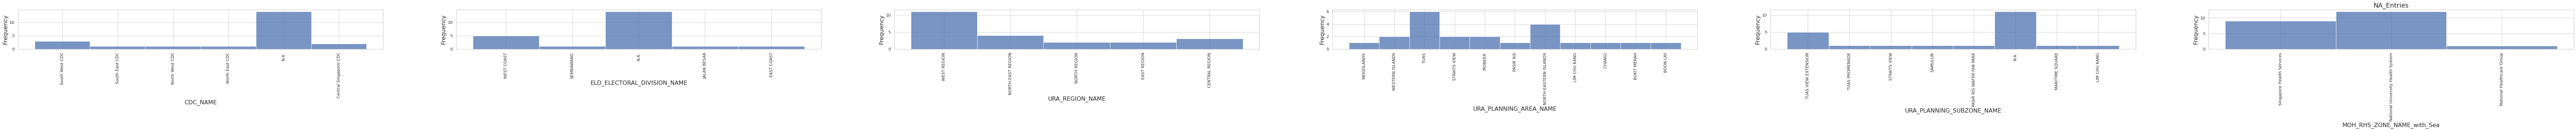

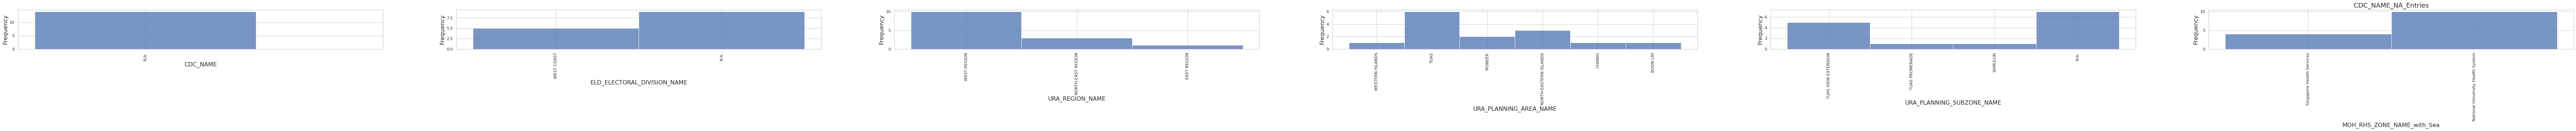

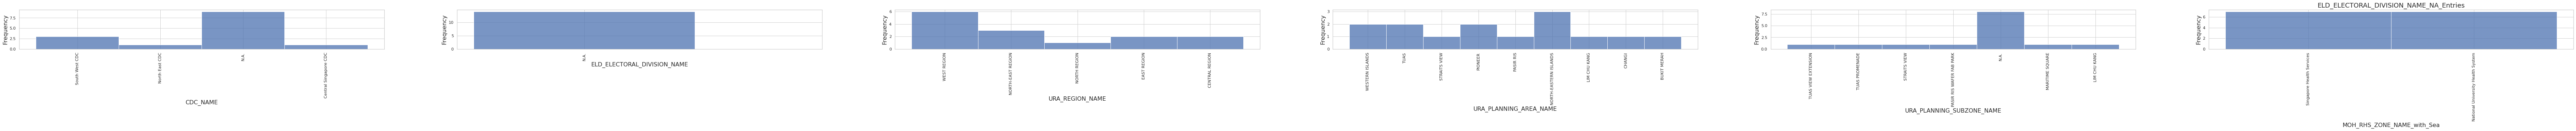

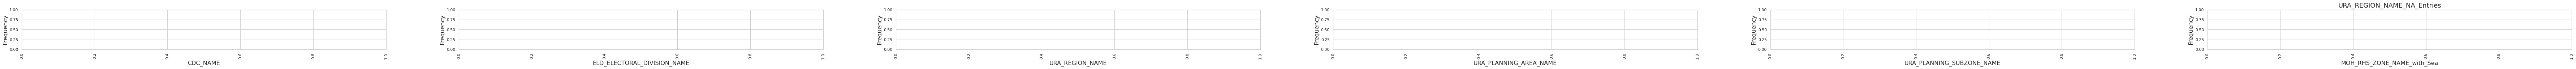

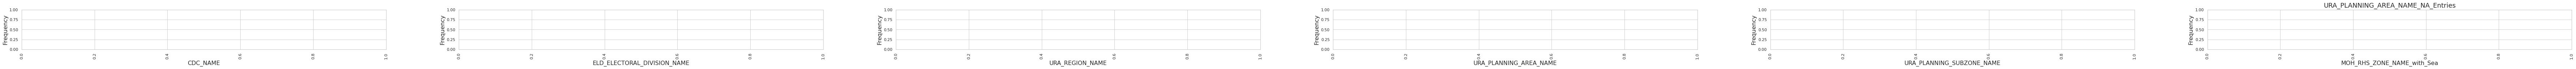

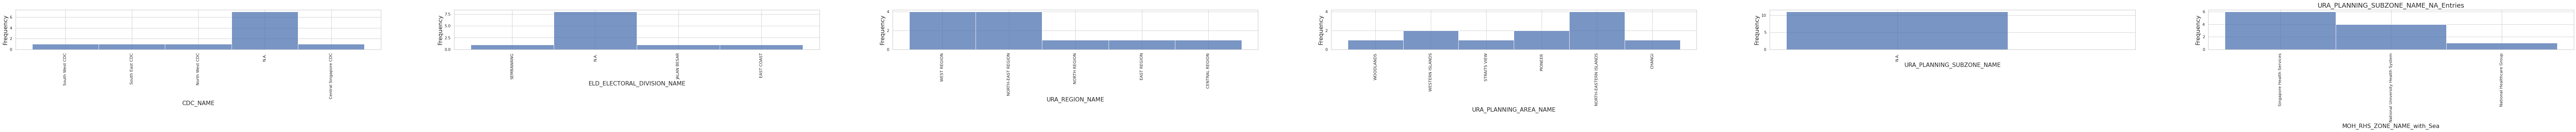

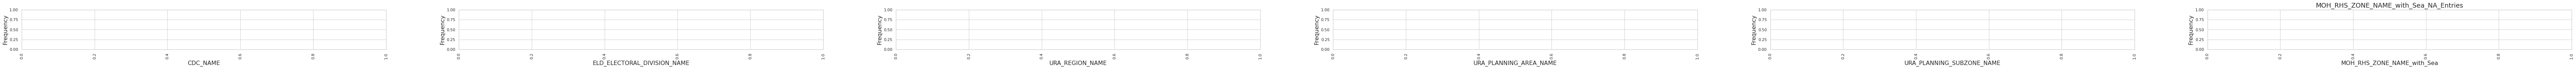

In [ ]:
# Plot the N.A. value distributions
# for outliers
col_list = ['CDC_NAME',
    'ELD_ELECTORAL_DIVISION_NAME',
                'URA_REGION_NAME',
                'URA_PLANNING_AREA_NAME',
                'URA_PLANNING_SUBZONE_NAME',
                'MOH_RHS_ZONE_NAME']

plot_na(entries = outliers, col_list=col_list)


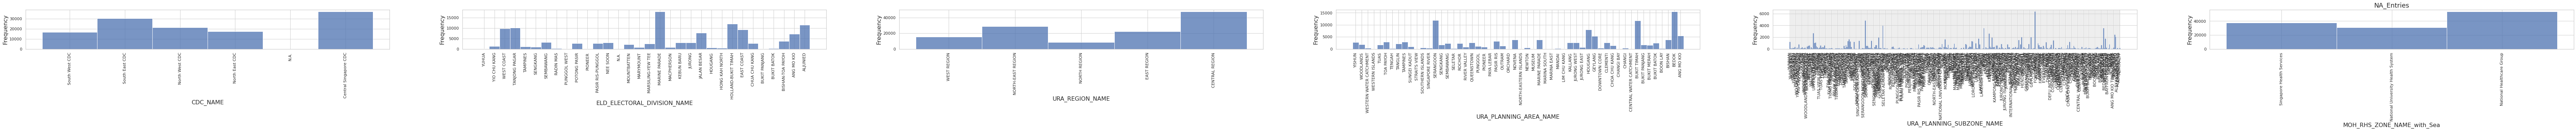

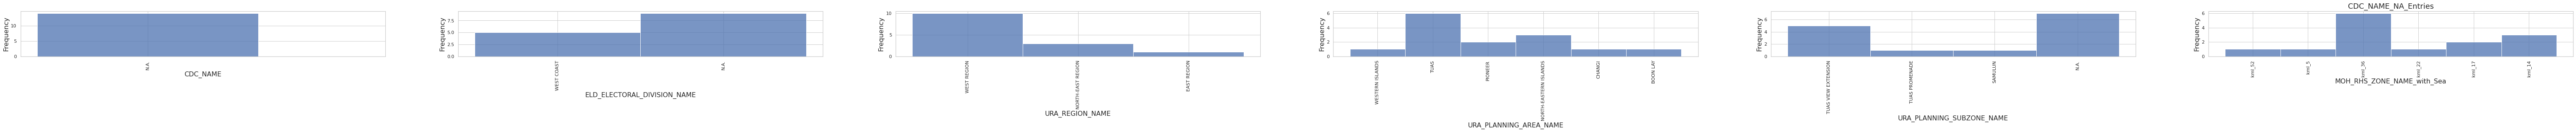

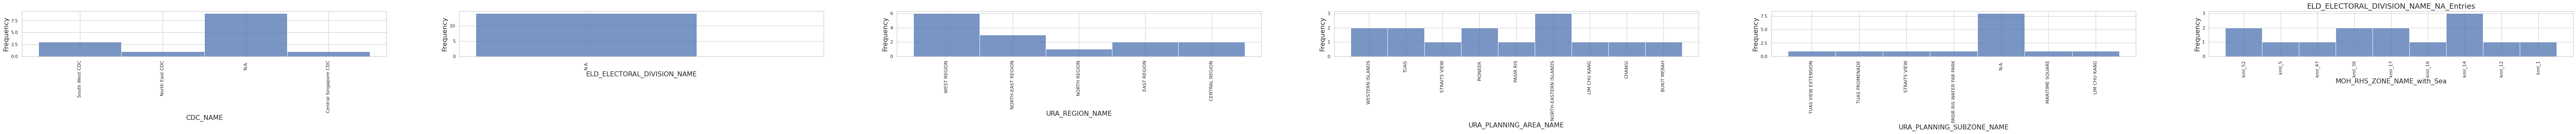

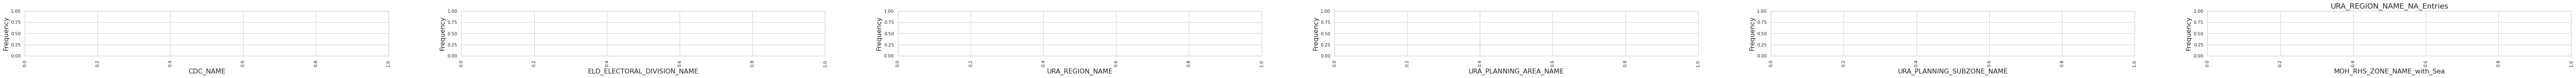

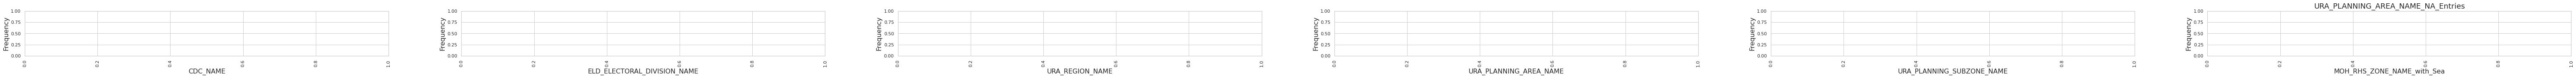

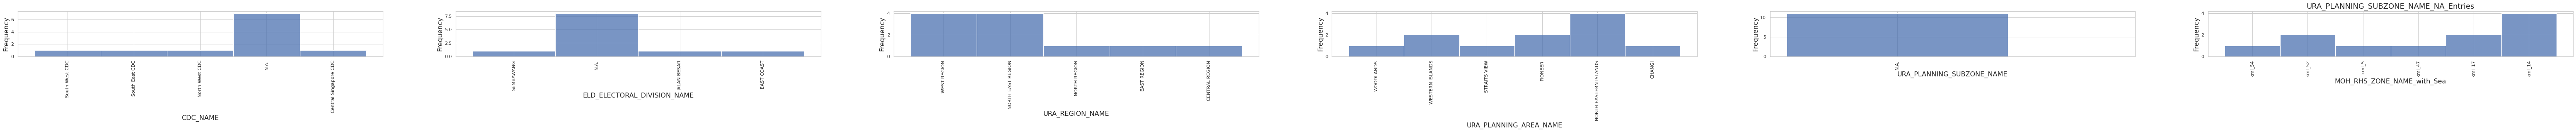

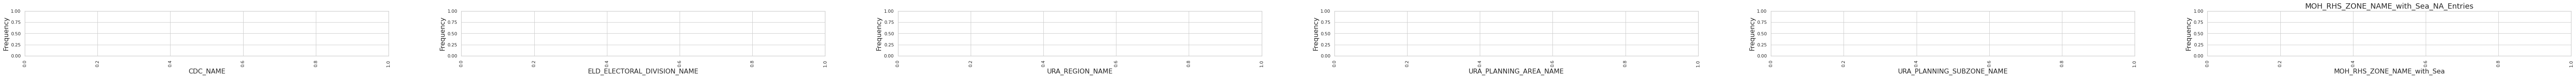

In [ ]:
# Plot the N.A. value distributions
# for new df
col_list = ['CDC_NAME',
    'ELD_ELECTORAL_DIVISION_NAME',
                'URA_REGION_NAME',
                'URA_PLANNING_AREA_NAME',
                'URA_PLANNING_SUBZONE_NAME',
                'MOH_RHS_ZONE_NAME']

plot_na(entries = new_df, col_list=col_list)

<Figure size 3600x360 with 0 Axes>

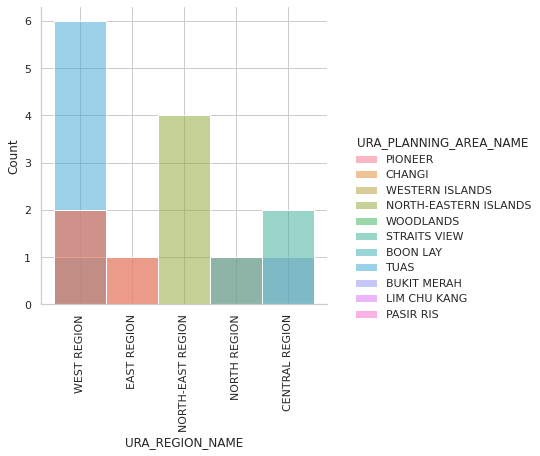

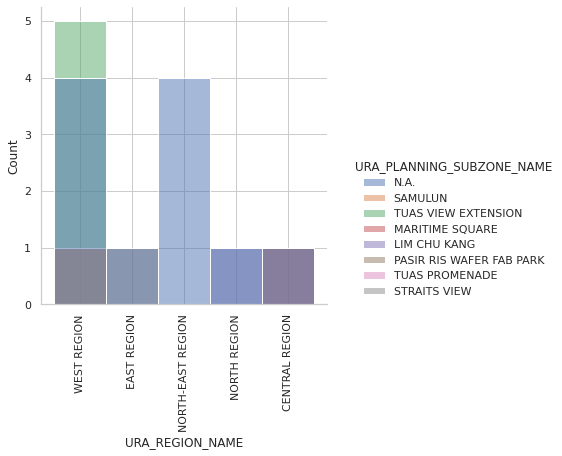

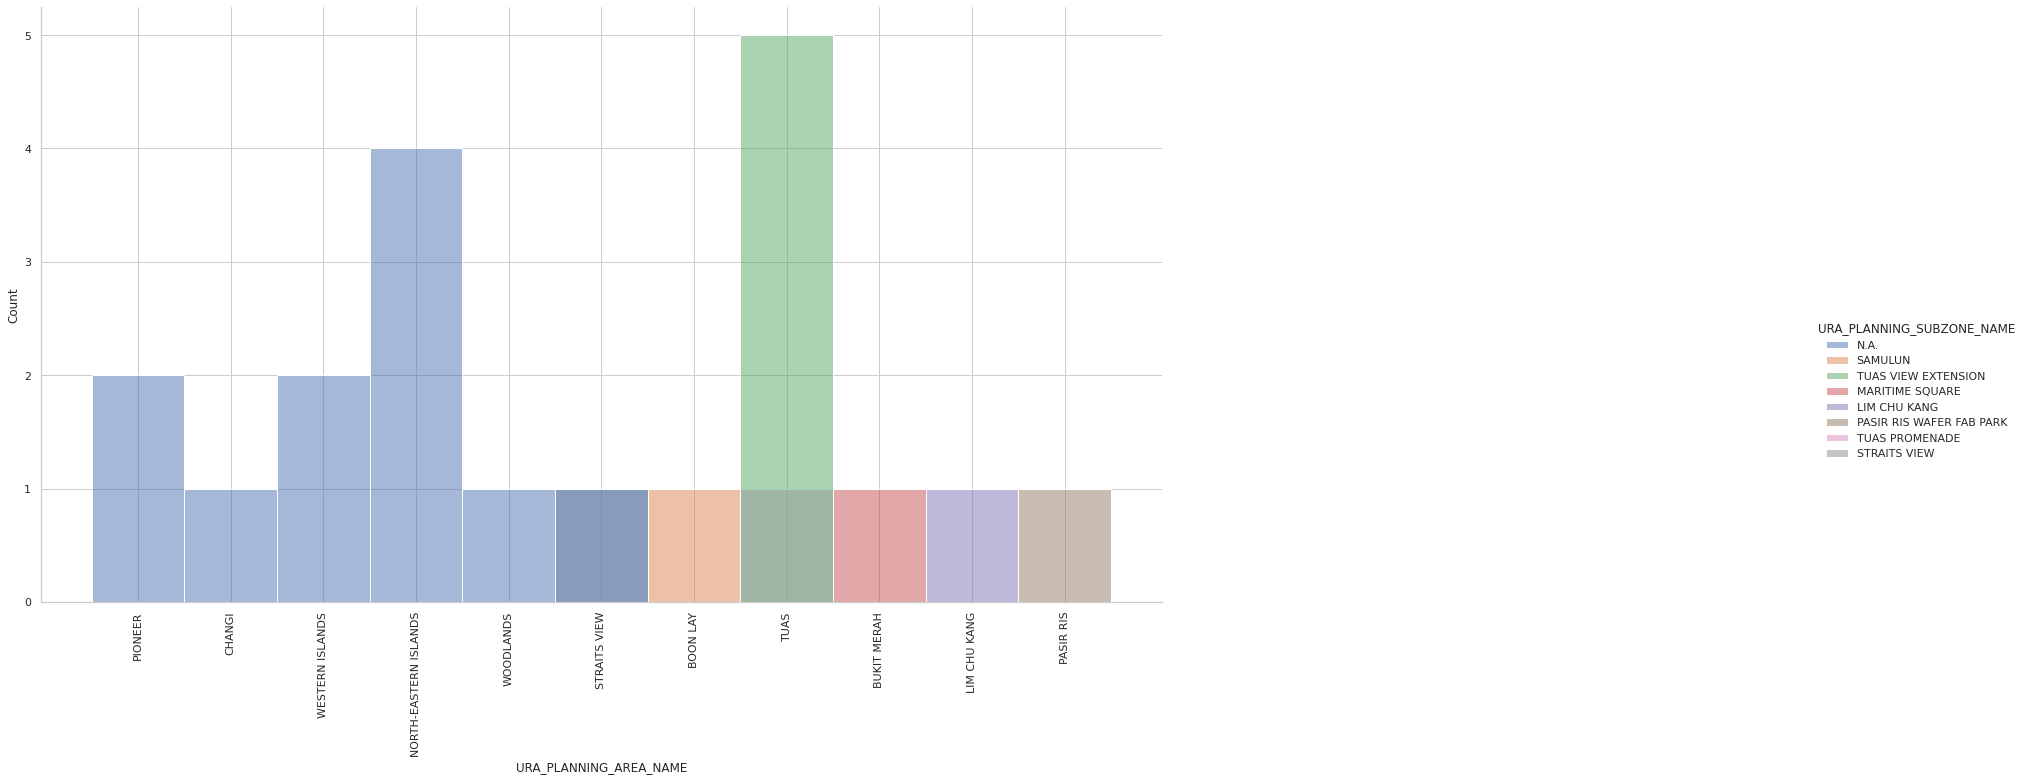

In [ ]:
plt.figure(figsize=(50,5))
sns.displot(outliers, x="URA_REGION_NAME", hue="URA_PLANNING_AREA_NAME") # , kde=True
plt.xticks(rotation=90)
plt.show()

sns.displot(outliers, x="URA_REGION_NAME", hue="URA_PLANNING_SUBZONE_NAME") # , kde=True
plt.xticks(rotation=90)
plt.show()

sns.displot(outliers, x="URA_PLANNING_AREA_NAME", hue="URA_PLANNING_SUBZONE_NAME") # , kde=True
plt.xticks(rotation=90)
plt.gcf().set_size_inches(30, 10)
plt.show()

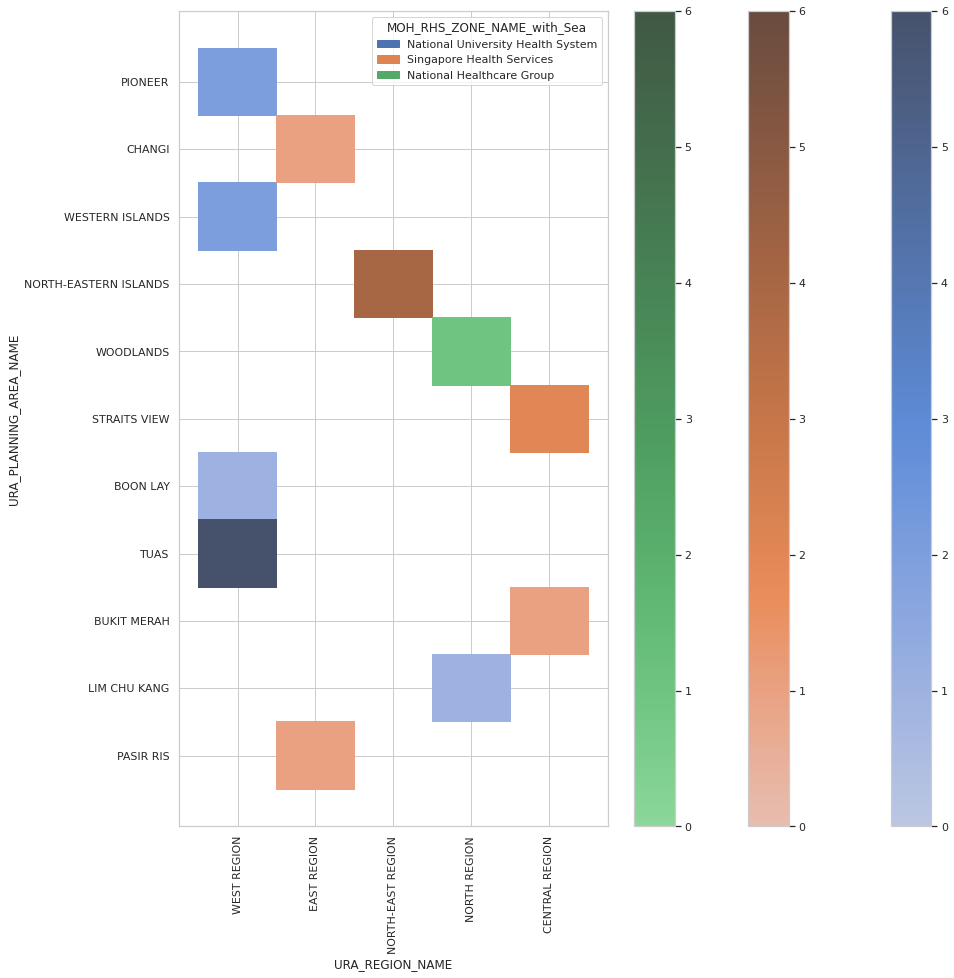

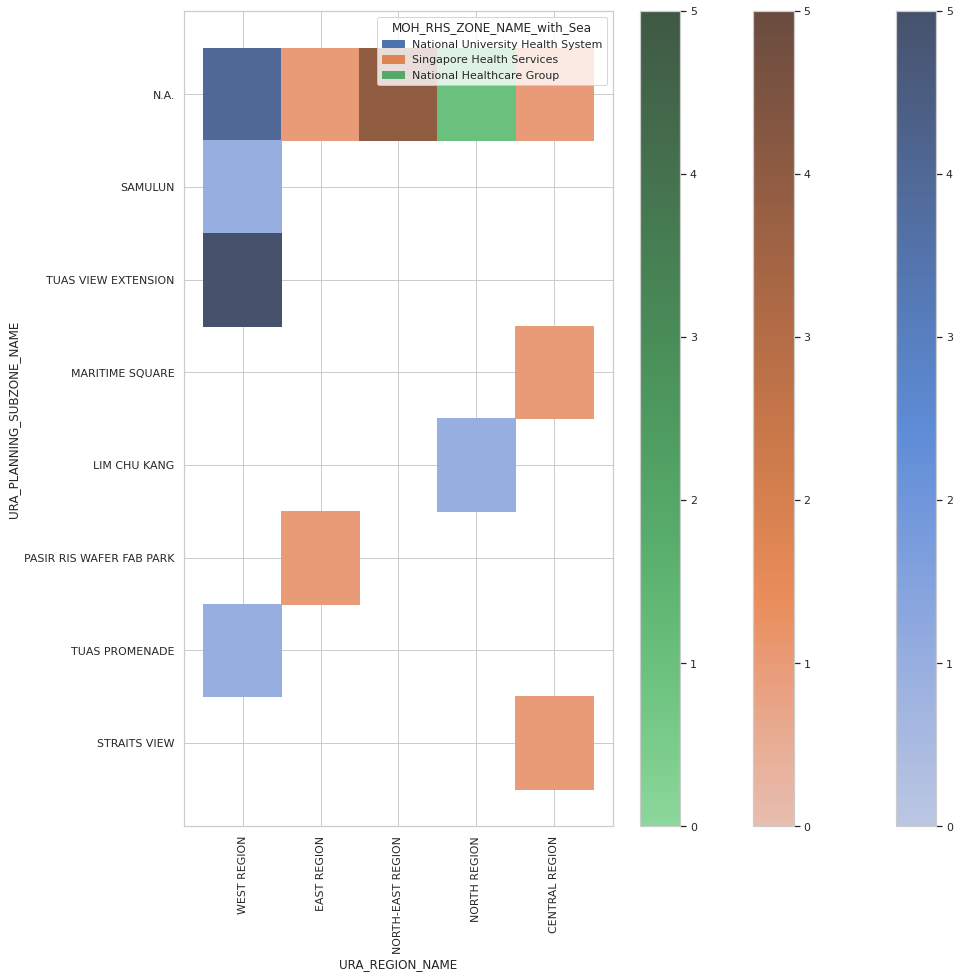

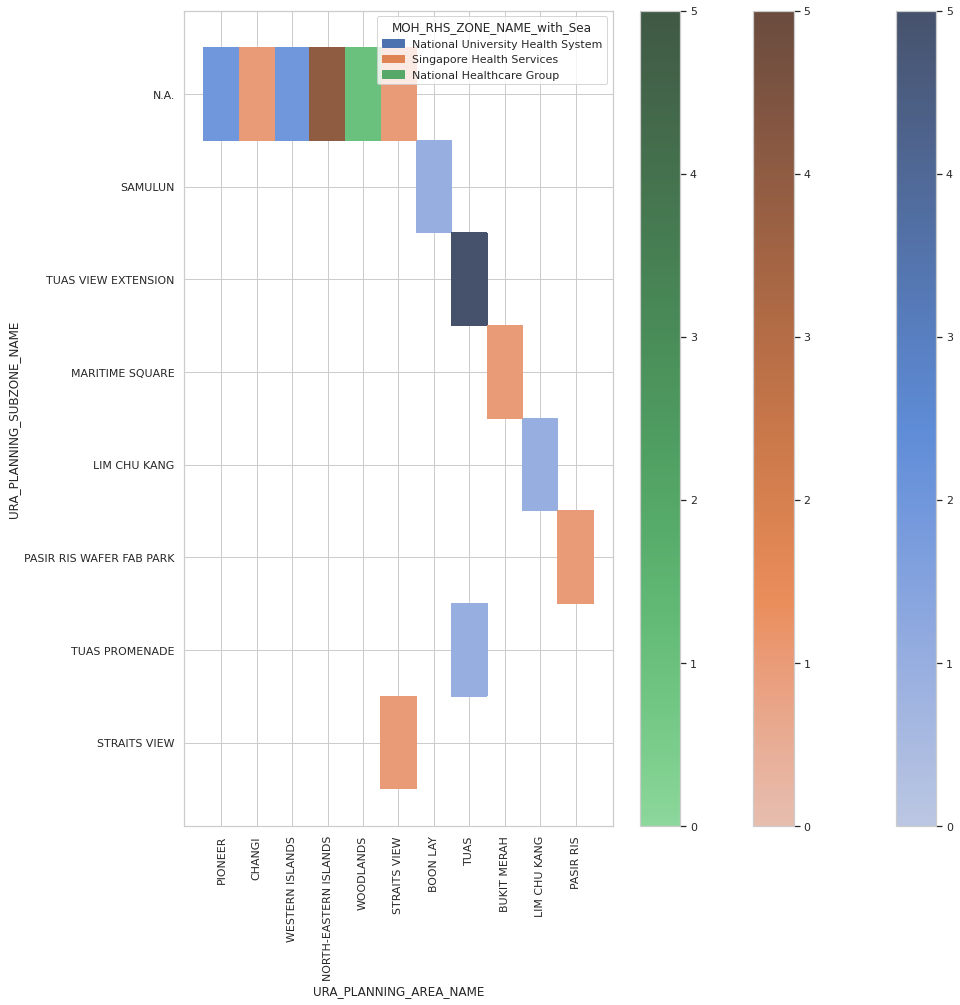

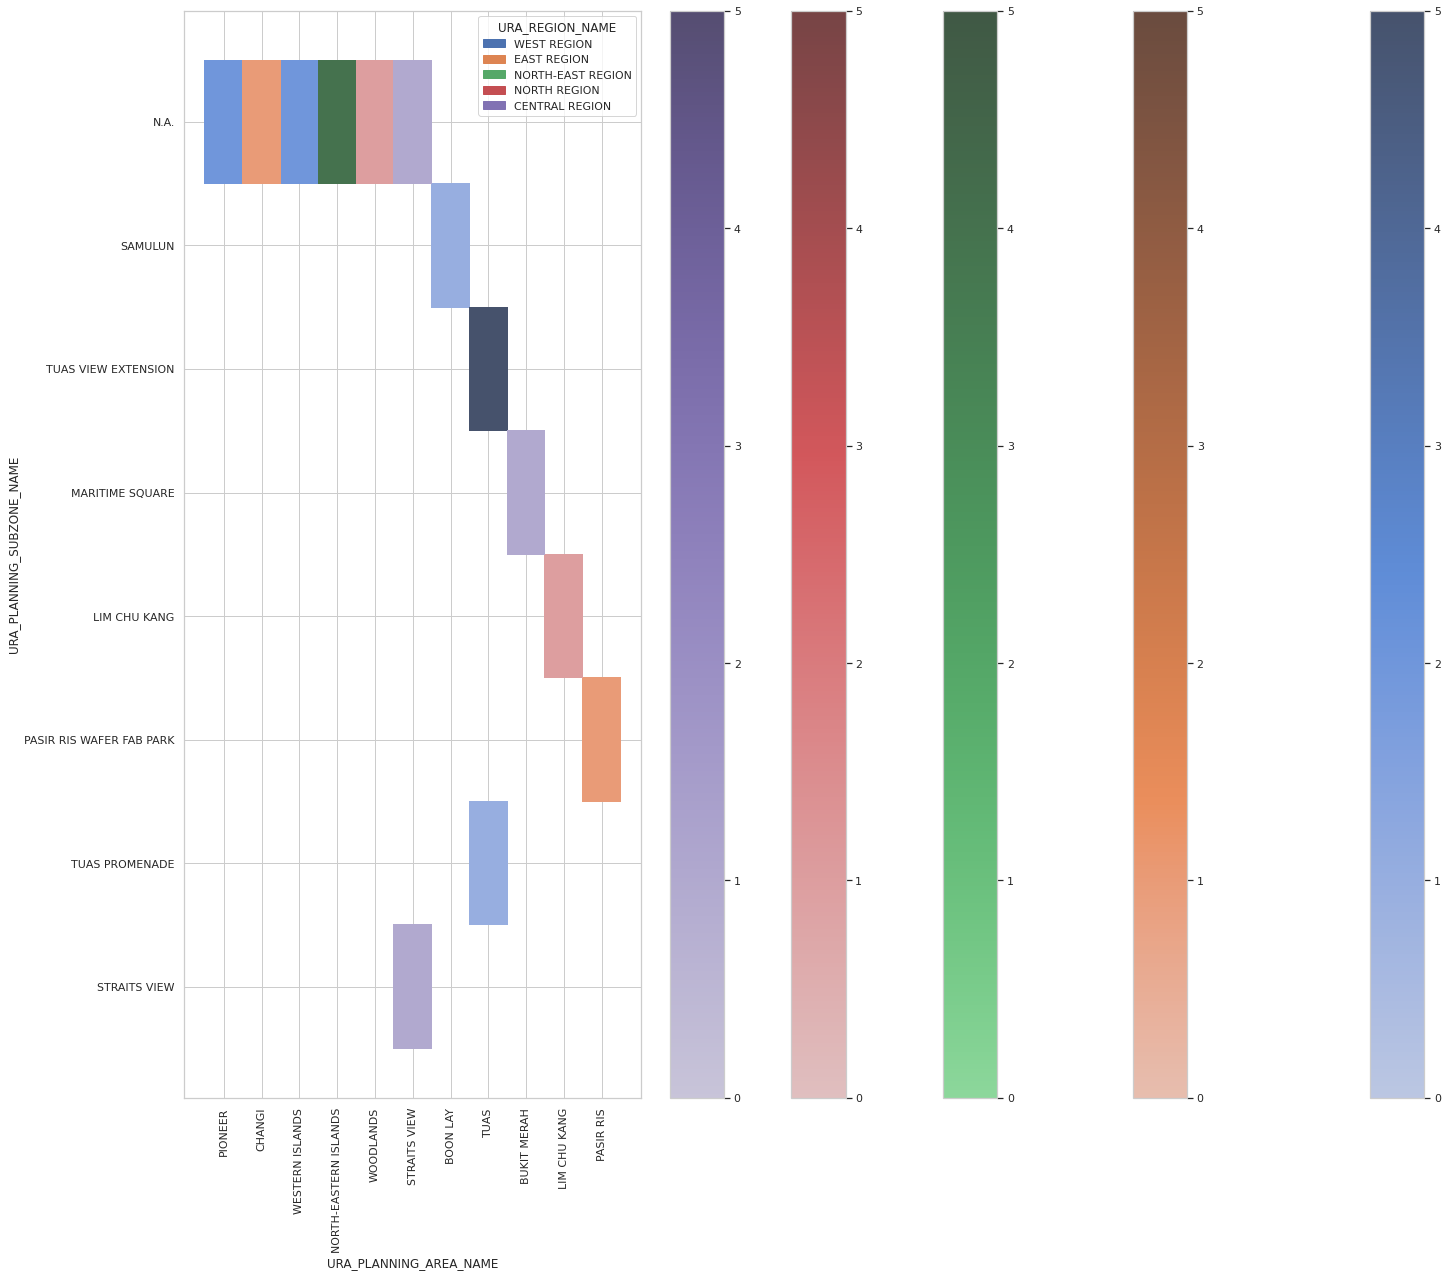

In [ ]:
# density analysis 
# density in hue colors

plt.figure(figsize=(15,15))
sns.histplot(outliers, x="URA_REGION_NAME", y='URA_PLANNING_AREA_NAME', hue="MOH_RHS_ZONE_NAME", cbar=True)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,15))
sns.histplot(outliers, x="URA_REGION_NAME", y='URA_PLANNING_SUBZONE_NAME', hue="MOH_RHS_ZONE_NAME", cbar=True)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,15))
sns.histplot(outliers, x="URA_PLANNING_AREA_NAME", y='URA_PLANNING_SUBZONE_NAME', hue="MOH_RHS_ZONE_NAME", cbar=True)
plt.xticks(rotation=90)
plt.show()


# plt.figure(figsize=(15,15))
# sns.histplot(outliers, x="URA_REGION_NAME", y='URA_PLANNING_AREA_NAME', hue="URA_PLANNING_SUBZONE_NAME", cbar=True)
# plt.xticks(rotation=90)
# plt.show()

# plt.figure(figsize=(15,15))
# sns.histplot(outliers, x="URA_REGION_NAME", y='URA_PLANNING_SUBZONE_NAME', hue="URA_PLANNING_AREA_NAME", cbar=True)
# plt.xticks(rotation=90)
# plt.show()


plt.figure(figsize=(25,20))
sns.histplot(outliers, x="URA_PLANNING_AREA_NAME", y='URA_PLANNING_SUBZONE_NAME', hue="URA_REGION_NAME", cbar=True)
plt.xticks(rotation=90)
plt.show()


In [ ]:
# geographical distribution of Missing data against LAT LONG

# plot for each entry containing unknown "N.A." values

for feature_name in col_list:
    plt.figure(figsize=(10,5))
    sns.histplot(new_df.query(feature_name + ' == "N.A."'), x="LONG", y='LAT', hue=feature_name, cbar=True)
    plt.xticks(rotation=90)
    plt.show()

plt.figure(figsize=(50,15))
sns.histplot(outliers, x="LONG", y='LAT', hue=feature_name, cbar=True)
plt.xticks(rotation=90)
plt.show()

'''
The horizontal axis stands for LONGITUDE, and the vertical axis stands for LATITUDE.
The blue rectangles represent the N.A. values of the attribute described in the top right labels. 
The density of the color suggests the times of occurrence of that labeled event.
'''

In [ ]:
# from scipy import stats
# outliers.groupby(['LAT','LONG']).agg(lambda x: stats.mode(x)[0][0])

In [ ]:
# RHS Boundary Robustness Analysis

# verify against rhs polyclinics
rhs_polyclinics_file_path="/content/gdrive/MyDrive/Polyclinics.csv"
polyclinics = pd.read_csv(rhs_polyclinics_file_path, on_bad_lines='skip')
rhs_file_path = "/content/gdrive/MyDrive/RHS_Excel_remove_duplicated.csv"
RHS_Excel = pd.read_csv(rhs_file_path, on_bad_lines='skip')
# RHS_Excel = rhs_excel(rhs_excel_file_path)


In [ ]:

# Compare the 2022 RHS Excel file against Policlinics RHS



# Compare Policlinics RHS against the 2022 RHS Excel file
compare_rhs_concat = compare_rhs(polyclinics, RHS_Excel,
                                 base_pc_col="POSTAL_ADDR", base_rhs_col='MOH_RHS_ZONE',
                                 ref_pc_col="SLA_PostalCode", ref_rhs_col="MOH_RHS")


+-------------------------+------+-------+-----------------------+
| RHS Simulation Category | Size | Ratio | Size Significant (5%) |
+-------------------------+------+-------+-----------------------+
|          Passed         |  23  |  1.0  |          True         |
|          Failed         |  0   |  0.0  |         False         |
|        N.A. Count       |  0   |  0.0  |         False         |
|          Total          |  23  |   1   |          N.A.         |
+-------------------------+------+-------+-----------------------+


In [ ]:
# verify new result (URA with Sea) against RHS Excel

# new_df = pd.read_csv("/content/gdrive/MyDrive/backup_Generated_RHS_3_URA_Sea.csv", dtype=str)

compare_rhs_concat = compare_rhs(new_df, RHS_Excel, ref_pc_col="SLA_PostalCode", ref_rhs_col="MOH_RHS", base_pc_col="POSTAL_ADDR", base_rhs_col='MOH_RHS_ZONE_NAME')

+-------------------------+--------+-----------------------+-----------------------+
| RHS Simulation Category |  Size  |         Ratio         | Size Significant (5%) |
+-------------------------+--------+-----------------------+-----------------------+
|          Passed         | 117277 |   0.9592818289640506  |          True         |
|          Failed         |  4978  |  0.04071817103594945  |         False         |
|        N.A. Count       |   65   | 0.0005316755960901395 |         False         |
|          Total          | 122255 |           1           |          N.A.         |
+-------------------------+--------+-----------------------+-----------------------+


In [ ]:
# -----------------------#
# validate RHS Excel postcodes, 133468 rows (done)

# rhs_excel_file_path="/content/gdrive/MyDrive/RHS_2022_Excel.csv"
# RHS_Excel = rhs_excel(rhs_excel_file_path)
table_of_arbitrary_values(RHS_Excel, 
                          target_attribute='SLA_PostalCode',
                          col_list=[
                              'URA_MP19_PlanningArea',	
                              'URA_MP19_Subzone',	
                              'MOH_RHS'])

# RHS_Excel = RHS_Excel.drop_duplicates(subset=["SLA_PostalCode"]) 
# rhs_excel_file_path="/content/gdrive/MyDrive/RHS_Excel_remove_duplicated.csv"
# RHS_Excel.to_csv(rhs_excel_file_path, header=True, index=False)

# RHS_Excel = pd.read_csv(rhs_excel_file_path, dtype=str)

SLA_PostalCode         
18895           nunique    1
18906           nunique    1
18907           nunique    1
18916           nunique    1
18925           nunique    1
                          ..
887327          nunique    1
887328          nunique    1
903808          nunique    1
918104          nunique    1
918146          nunique    1
Name: URA_MP19_PlanningArea, Length: 122216, dtype: int64
SLA_PostalCode         
18895           nunique    1
18906           nunique    1
18907           nunique    1
18916           nunique    1
18925           nunique    1
                          ..
887327          nunique    1
887328          nunique    1
903808          nunique    1
918104          nunique    1
918146          nunique    1
Name: URA_MP19_Subzone, Length: 122216, dtype: int64
SLA_PostalCode         
18895           nunique    1
18906           nunique    1
18907           nunique    1
18916           nunique    1
18925           nunique    1
                          ..
88732

In [ ]:
# validate RHS Excel postcodes, 133468 rows (done)
dulicated_RHS_Excel = RHS_Excel[RHS_Excel.SLA_PostalCode.isin(RHS_Excel[RHS_Excel.duplicated(subset=['SLA_PostalCode'])].SLA_PostalCode)]
dulicated_RHS_Excel.sort_values(by='SLA_PostalCode', ascending = False)

,SLA_PostalCode,URA_MP19_PlanningArea,URA_MP19_Subzone,MOH_RHS,Unnamed: 4
35593,809049,SERANGOON,SELETAR HILLS,National Healthcare Group,NaN
65800,809049,SERANGOON,SELETAR HILLS,National Healthcare Group,NaN
91312,809047,SERANGOON,SELETAR HILLS,National Healthcare Group,NaN
100766,809047,SERANGOON,SELETAR HILLS,National Healthcare Group,NaN
96348,809045,SERANGOON,SELETAR HILLS,National Healthcare Group,NaN
...,...,...,...,...,...
113863,48820,SINGAPORE RIVER,BOAT QUAY,Singapore Health Services,NaN
93284,48820,SINGAPORE RIVER,BOAT QUAY,Singapore Health Services,NaN
124232,48820,SINGAPORE RIVER,BOAT QUAY,Singapore Health Services,NaN
29194,39595,DOWNTOWN CORE,MARINA CENTRE,Singapore Health Services,NaN


In [ ]:
# check 122255 complete csv list v.s. rhs excel, vise versa (done)
target_attribute = 'SLA_PostalCode'
postcode_list_1 = set(RHS_Excel[target_attribute].astype(str))
target_attribute = 'POSTAL_ADDR'
missing_in_rhs_excel = result[~result[target_attribute].astype(str).isin(postcode_list_1)]

target_attribute = 'POSTAL_ADDR'
postcode_list_2 = set(result[target_attribute].astype(str))
target_attribute = 'SLA_PostalCode'
missing_in_complete_csv = RHS_Excel[~RHS_Excel[target_attribute].astype(str).isin(postcode_list_2)]

print(
len(postcode_list_1),
len(postcode_list_2)
)  # 122216 122255
print(
    len(missing_in_rhs_excel),
    len(missing_in_complete_csv)
) # 65 29

missing_in_rhs_excel.to_csv("/content/gdrive/MyDrive/missing_in_rhs_excel.csv", header=True, index=False)
missing_in_complete_csv.to_csv("/content/gdrive/MyDrive/missing_in_complete_csv.csv", header=True, index=False)


122216 122255


In [ ]:
# Duplicate Postal Code Analysis
table_of_arbitrary_values(result,
                          target_attribute='POSTAL_ADDR', 
                          categories = [
                              'Attribute Name', 
                              'Count Postcodes Having Multi Attributes',
                              'Max Multi Attributes',
                              'Postcodes Having Multi Attributes',
                              'Ratio',
                              'Size Significant (5%)'], 
                          col_list=[
                              'CDC_NAME',	
                              'ELD_ELECTORAL_DIVISION_NAME',	
                              'URA_REGION_NAME',	
                              'URA_PLANNING_AREA_NAME',	
                              'URA_PLANNING_SUBZONE_NAME'])

# Save csv
# result.loc[result['POSTAL_ADDR'].isin(unique_duplicated_postcode_list)].to_csv('/content/gdrive/MyDrive/Duplicated Postcode.csv', index=False)


+--------------------------------+-----------------------------------------+----------------------+--------------------------------------------------------------------------+------------------------+-----------------------+
|         Attribute Name         | Count Postcodes Having Multi Attributes | Max Multi Attributes |                    Postcodes Having Multi Attributes                     |         Ratio          | Size Significant (5%) |
+--------------------------------+-----------------------------------------+----------------------+--------------------------------------------------------------------------+------------------------+-----------------------+
|            CDC_NAME            |                    11                   |          2           |                              <IntegerArray>                              | 8.997587010756207e-05  |         False         |
|                                |                                         |                      | [ 98

In [ ]:
result['REFERENCE_DT'].describe()
# [result['HOUSE_BLK_NO'].unique()]

count         200002
unique          2949
top       2017-11-10
freq            5932
Name: REFERENCE_DT, dtype: object

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 200002 entries, 0.0 to 200001.0
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   LAT                          200002 non-null  float64
 1   LONG                         200002 non-null  float64
 2   BUILDING_NAME                122221 non-null  object 
 3   HOUSE_BLK_NO                 200002 non-null  object 
 4   ROAD_NAME                    200002 non-null  object 
 5   POSTAL_ADDR                  200002 non-null  int64  
 6   MULTI_ADDR_IND               200001 non-null  object 
 7   CDC_NAME                     199991 non-null  object 
 8   ELD_ELECTORAL_DIVISION_NAME  200002 non-null  object 
 9   URA_REGION_NAME              200002 non-null  object 
 10  URA_PLANNING_AREA_NAME       200002 non-null  object 
 11  URA_PLANNING_SUBZONE_NAME    200002 non-null  object 
 12  MOH_RHS_ZONE_NAME            200002 non-null  object

In [ ]:
#------------------------------#
# addressing duplicated postcode


,LAT,LONG,BUILDING_NAME,HOUSE_BLK_NO,ROAD_NAME,POSTAL_ADDR,MULTI_ADDR_IND,CDC_NAME,ELD_ELECTORAL_DIVISION_NAME,URA_REGION_NAME,URA_PLANNING_AREA_NAME,URA_PLANNING_SUBZONE_NAME,MOH_RHS_ZONE_NAME,REFERENCE_DT
266.0,1.2871506161666249,103.84515373686284,HAVELOCK2,2,HAVELOCK ROAD,59763,n,Central Singapore CDC,JALAN BESAR,CENTRAL REGION,SINGAPORE RIVER,CLARKE QUAY,Singapore Health Services,2022-04-20
267.0,1.2867285266948167,103.84490133107398,HAVELOCK2,2,HAVELOCK ROAD,59763,n,Central Singapore CDC,JALAN BESAR,CENTRAL REGION,OUTRAM,PEARL'S HILL,Singapore Health Services,2022-04-20
2004.0,1.2993483176115557,103.8549800421641,BUGIS+,201,VICTORIA STREET,188067,n,Central Singapore CDC,JALAN BESAR,CENTRAL REGION,DOWNTOWN CORE,BUGIS,Singapore Health Services,2022-05-31
2011.0,1.2996036899997971,103.85424234739466,BUGIS+,201,VICTORIA STREET,188067,n,Central Singapore CDC,JALAN BESAR,CENTRAL REGION,ROCHOR,VICTORIA,National Healthcare Group,2022-05-31
2887.0,1.2571523568500578,103.83966514501854,SCDF MARINE COMMAND HQ,19,BRANI WAY,98002,n,South West CDC,WEST COAST,CENTRAL REGION,BUKIT MERAH,CITY TERMINALS,Singapore Health Services,2022-03-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199749.0,1.4359976424668608,103.78897414056182,NaN,11,WOODLANDS SQUARE,737736,n,North West CDC,MARSILING-YEW TEE,NORTH REGION,WOODLANDS,MIDVIEW,National Healthcare Group,2020-04-03
199832.0,1.287194163378473,103.81466260443848,BLK A,20,LENGKOK BAHRU,159053,n,Central Singapore CDC,RADIN MAS,CENTRAL REGION,BUKIT MERAH,REDHILL,Singapore Health Services,2016-08-25
199833.0,1.2870706979218334,103.81450095693528,BLK A,20,LENGKOK BAHRU,159053,n,Central Singapore CDC,RADIN MAS,CENTRAL REGION,BUKIT MERAH,REDHILL,Singapore Health Services,2016-08-25
199895.0,1.468711154920996,103.8026113595417,SENOKO INDUSTRIAL ESTATE,45,SENOKO ROAD,758114,n,North West CDC,SEMBAWANG,NORTH REGION,SEMBAWANG,SENOKO NORTH,National Healthcare Group,2021-10-13


In [ ]:
# addressing duplicated postcode
if __name__ == '__main__':
    part_series = 0
    batch_size = 9
    num_batch = int(bulk/batch_size) # +1


    postcode_name='POSTAL_ADDR'
    csv_file_path="/content/gdrive/MyDrive/Duplicated Postcode_index.csv"
    duplicated = pd.read_csv(csv_file_path, dtype=str, index_col=0)
    df = deal_with_arbitrary_postcodes(duplicated, postcode_name='POSTAL_ADDR', result=result)
    df.reset_index(drop = True, inplace = True)
    # or read from previous csv file
    # df = pd.read_csv("/content/gdrive/MyDrive/Complete_removing_arbitrary_attributes.csv", dtype=str)
    
    # remove all duplicated entries
    # repeated containing redundant entries of duplicated section, 
    repeated = df[df.duplicated(subset=['POSTAL_ADDR'])]
    # processed containing single entry per postcode, 
    processed = df[~df.index.isin(repeated.index)]
    # unique containing postcodes that never repeat themselves
    unique = df[~df.POSTAL_ADDR.isin(repeated['POSTAL_ADDR'])]

    # get the dupicated postcodes list, single entry per postcode
    # extract = processed[processed.POSTAL_ADDR.isin(repeated['POSTAL_ADDR'])] 
    extract = processed[~processed.POSTAL_ADDR.isin(unique['POSTAL_ADDR'])] 

    extract = extract.drop(['LAT', 'LONG'], axis = 1)

    bulk = len(extract)

    out = display(0, num_batch, display_id=True) # num_batch+1
    for ii in range(num_batch+1):
        out.update(progress(ii+1, num_batch))
        if ii * batch_size <= len(extract) and ii >= 1327:
            inputs = extract[ii*batch_size+part_series*bulk:(ii+1)*batch_size+part_series*bulk]
            try: 
                pipeline(inputs, part_series=part_series)
            except:
                print(ii, "  not processed")
                pass
    # read back from the csv make a full list of processed Complete csv
    extract_df = pd.read_csv("/content/gdrive/MyDrive/Generated Part0.csv", index_col=0, dtype=str)
    # remove lat lng headers
    extract_df = extract_df[extract_df['LAT']!= 'LAT']
    # save
    frames = [unique, extract_df]
    result  = pd.concat(frames)
    result.to_csv("/content/gdrive/MyDrive/Complete_removing_duplicated.csv", header=True, index=False)

In [ ]:
na_analysis(result)

The overall percentage of data that is missing is important. 
Generally, if less than 5% of values are missing then it is acceptable to ignore them. 
Schafer ( 1999 ) asserted that a missing rate of 5% or less is inconsequential. 
Bennett ( 2001 ) maintained that statistical analysis is likely to be biased when more than 10% of data are missing.
+-----------------------------+---------------+------------------------+----------------+----------------------------------------------+-------------------------+---------------------------------+
|             Name            | Observed Data | Ratio of Observed Data | Missing Values | Ratio of Missing Values v.s. Observed Values | Ratio of Missing Values | Missing Values Significant (5%) |
+-----------------------------+---------------+------------------------+----------------+----------------------------------------------+-------------------------+---------------------------------+
|           CDC_NAME          |     122241    |   0.999893664

In [ ]:
# to-do: RHS Simulation Category Check, 122255(complete csv) v.s. 133468(rhs excel)
# to-do:  failed RHS simulation LAT/LONG? 8083

# RHS boundaries updating, plot failed, (LAT/LONG? 8083)  (done)
# 575 outliers


# validate RHS Excel postcodes, 133468 rows (done)
# 17428 duplicated, 122216 unique

# check 122255 complete csv list v.s. rhs excel, vise versa (done)
# drew on Google Earth

# mapping URA (with sea) (done)
# Complete_URA_Sea.csv

# --------
# set(RHS_Excel.SLA_PostalCode)
# RHS_Excel[target_attribute].unique()


,SLA_PostalCode,URA_MP19_PlanningArea,URA_MP19_Subzone,MOH_RHS,Unnamed: 4,MOH_RHS_ZONE
0,208413,ROCHOR,LITTLE INDIA,Singapore Health Services,NaN,National Healthcare Group
1,208422,ROCHOR,LITTLE INDIA,Singapore Health Services,NaN,National Healthcare Group
2,209854,KALLANG,LAVENDER,National Healthcare Group,NaN,National Healthcare Group
3,209854,KALLANG,LAVENDER,National Healthcare Group,NaN,National Healthcare Group
4,208413,ROCHOR,LITTLE INDIA,Singapore Health Services,NaN,National Healthcare Group
...,...,...,...,...,...,...
133450,249058,TANGLIN,CHATSWORTH,Singapore Health Services,NaN,Singapore Health Services
133457,49368,SINGAPORE RIVER,BOAT QUAY,Singapore Health Services,NaN,Singapore Health Services
133458,258052,TANGLIN,TYERSALL,Singapore Health Services,NaN,Singapore Health Services
133459,509374,PASIR RIS,PASIR RIS PARK,Singapore Health Services,NaN,Singapore Health Services


In [ ]:
# len(repeated['POSTAL_ADDR'].unique())
# extract = extract.drop_duplicates(subset=['LAT','LONG', 'POSTAL_ADDR']) 
      # extract[extract.duplicated(subset=['LAT', 'LONG'])].drop(['LAT', 'LONG'], axis = 1)

      
# print(len(repeated), len(processed), len(concatenated)-len(repeated)-len(processed), 
# len(repeated.POSTAL_ADDR.unique(), len(unique), len(processed)-len(unique)-len(repeated.POSTAL_ADDR.unique(), len(extract)) )
#       76469                            122255          0          -- 89648                                           32607
# unique.duplicated(subset=['LAT', 'LONG'])


In [ ]:
res = extract[extract.duplicated(subset=['LAT', 'LONG'])].drop(['LAT', 'LONG'], axis = 1)
res = pipeline(res)

In [ ]:
# res

,LAT,LONG,BUILDING_NAME,HOUSE_BLK_NO,ROAD_NAME,POSTAL_ADDR,MULTI_ADDR_IND,CDC_NAME,ELD_ELECTORAL_DIVISION_NAME,URA_REGION_NAME,URA_PLANNING_AREA_NAME,URA_PLANNING_SUBZONE_NAME,MOH_RHS_ZONE_NAME,REFERENCE_DT
2454,1.30140119656286,103.839278318939,PERANAKAN PLACE,182A,ORCHARD ROAD,238847,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,ORCHARD,SOMERSET,Singapore Health Services,2022-05-10
2458,1.30140119656286,103.839278318939,PERANAKAN PLACE,186,ORCHARD ROAD,238849,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,ORCHARD,SOMERSET,Singapore Health Services,2022-05-10
2517,1.30148487514509,103.839139972614,PERANAKAN PLACE,180A,ORCHARD ROAD,238846,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,ORCHARD,SOMERSET,Singapore Health Services,2022-05-10
2589,1.30696027778789,103.852334844726,LITTLE INDIA CONSERVATION AREA,102,SERANGOON ROAD,218007,y,Central Singapore CDC,JALAN BESAR,CENTRAL REGION,ROCHOR,LITTLE INDIA,National Healthcare Group,2022-05-10
2607,1.30454806471762,103.850224325777,NaN,217,SELEGIE ROAD,188338,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,ROCHOR,SELEGIE,National Healthcare Group,2022-05-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195216,1.36254276452963,103.887233438924,NaN,1007,UPPER SERANGOON ROAD,534745,y,North East CDC,ALJUNIED,NORTH-EAST REGION,HOUGANG,KOVAN,National Healthcare Group,2017-11-10
196131,1.30433375961181,103.854453282175,LITTLE INDIA CONSERVATION AREA,29A,JALAN BESAR,208797,y,Central Singapore CDC,JALAN BESAR,CENTRAL REGION,ROCHOR,LITTLE INDIA,National Healthcare Group,2019-06-27
196270,1.29874865744547,103.840315206939,EBER GARDENS,3A,EBER ROAD,239757,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,RIVER VALLEY,OXLEY,Singapore Health Services,2017-11-10
196313,1.3369337422602,103.801432387255,NaN,83A,LINDEN DRIVE,288721,y,North West CDC,HOLLAND-BUKIT TIMAH,CENTRAL REGION,BUKIT TIMAH,HILLCREST,National University Health System,2018-08-03


In [ ]:
# extract[extract.duplicated(subset=['LAT', 'LONG'])]

,LAT,LONG,BUILDING_NAME,HOUSE_BLK_NO,ROAD_NAME,POSTAL_ADDR,MULTI_ADDR_IND,CDC_NAME,ELD_ELECTORAL_DIVISION_NAME,URA_REGION_NAME,URA_PLANNING_AREA_NAME,URA_PLANNING_SUBZONE_NAME,MOH_RHS_ZONE_NAME,REFERENCE_DT
2454,1.301401196562915,103.83927831893948,PERANAKAN PLACE,182A,ORCHARD ROAD,238847,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,ORCHARD,SOMERSET,Singapore Health Services,2022-05-10
2458,1.301401196562915,103.83927831893948,PERANAKAN PLACE,186,ORCHARD ROAD,238849,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,ORCHARD,SOMERSET,Singapore Health Services,2022-05-10
2517,1.301401196562915,103.83927831893948,PERANAKAN PLACE,180A,ORCHARD ROAD,238846,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,ORCHARD,SOMERSET,Singapore Health Services,2022-05-10
2589,1.3069602775141187,103.85233484499766,LITTLE INDIA CONSERVATION AREA,102,SERANGOON ROAD,218007,y,Central Singapore CDC,JALAN BESAR,CENTRAL REGION,ROCHOR,LITTLE INDIA,National Healthcare Group,2022-05-10
2607,1.3045480644438625,103.85022432604906,NaN,217,SELEGIE ROAD,188338,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,ROCHOR,SELEGIE,National Healthcare Group,2022-05-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195216,1.362542764255884,103.88723343919636,NaN,1007,UPPER SERANGOON ROAD,534745,y,North East CDC,ALJUNIED,NORTH-EAST REGION,HOUGANG,KOVAN,National Healthcare Group,2017-11-10
196131,1.3043337596118043,103.8544532821752,LITTLE INDIA CONSERVATION AREA,29A,JALAN BESAR,208797,y,Central Singapore CDC,JALAN BESAR,CENTRAL REGION,ROCHOR,LITTLE INDIA,National Healthcare Group,2019-06-27
196270,1.2987486574454372,103.840315207211,EBER GARDENS,3A,EBER ROAD,239757,y,Central Singapore CDC,TANJONG PAGAR,CENTRAL REGION,RIVER VALLEY,OXLEY,Singapore Health Services,2017-11-10
196313,1.336933742533972,103.8014323872552,NaN,83A,LINDEN DRIVE,288721,y,North West CDC,HOLLAND-BUKIT TIMAH,CENTRAL REGION,BUKIT TIMAH,HILLCREST,National University Health System,2018-08-03


In [ ]:
# rhs_mismatched_file_path = "/content/gdrive/MyDrive/backup_compare_rhs_ura_sea_diff_765cc9e6-689c-4509-9f37-f93576b67d3a.csv"
# rhs_mismatched = pd.read_csv(rhs_mismatched_file_path, on_bad_lines='skip')
# rhs_mismatched = rhs_mismatched[['POSTAL_ADDR', 'MOH_RHS_ZONE_NAME','MOH_RHS']]

# duplicated_file_path = '/content/gdrive/MyDrive/Duplicated Postcode.csv'
# duplicated = pd.read_csv(duplicated_file_path, on_bad_lines='skip')
# duplicated = duplicated[['POSTAL_ADDR', 'MOH_RHS_ZONE_NAME']]

# compare mismatched vs missing_in_RHS_Excel
na_analysis(rhs_mismatched, col_list = ['MOH_RHS','MOH_RHS_ZONE_NAME'])

# compare mismatched vs duplicated postcodes
ref_pc_col="POSTAL_ADDR"
ref_rhs_col="MOH_RHS_ZONE_NAME"
base_pc_col="POSTAL_ADDR"
base_rhs_col='MOH_RHS_ZONE_NAME'
# to-do: for part in duplicated:
    compare_rhs_concat = compare_rhs(rhs_mismatched, part, ref_pc_col="POSTAL_ADDR", ref_rhs_col="MOH_RHS_ZONE_NAME", base_pc_col="POSTAL_ADDR", base_rhs_col='MOH_RHS_ZONE_NAME')



In [ ]:

base_df = rhs_mismatched
ref_df = part # to-do

ref_df[ref_pc_col] = ref_df[ref_pc_col].astype(str)
base_df[base_pc_col] = base_df[base_pc_col].astype(str)

ref_df = ref_df.set_index(ref_pc_col)
base_df = base_df.set_index(base_pc_col)
base_df.join(ref_df, how="left")

# base_df = base_df.join(ref_df, how="left")  # ?

# df_failed = base_df[base_df[base_rhs_col] != base_df[ref_rhs_col]]
# df_passed = base_df[base_df[base_rhs_col] == base_df[ref_rhs_col]]